# Police Department Incident Data of San Francisco and Chicago 
## A Project on Assesing and Comparing ML Models for two Large City Crime Datasets 
### Eren Tumkaya

In [433]:
import pandas as pd
import numpy as np
import requests
from datetime import datetime
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
import matplotlib.pyplot as plt
import holidays
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
import time
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV


## About the Project

San Francisco and Chicago are two mega cities in the US, and as in any large city, crime is a significant problem that requires thorough analysis. This project will focus on exploring the relationships between selected features and incident counts in both cities. The ultimate goal is to train efficient machine learning algorithms to explain the variation in crime counts separately for both cities. Afterwards, the results will be compared.

The main datasets are from Chicago's and San Francisco's open data portals. Additionally, other datasets will be utilized to create additional features such as daily and hourly temperature, precipitation, moon status, etc. Feature engineering will be a crucial part of the project.

Exploring the data will involve utilizing exploratory machine learning models with appropriate parameters, validation techniques, and a variety of statistical tests.

## Ingesting the Datasets 

There are 8 datasets I had planned to use prior to starting this project. I will acces them all with their "API's". I will start by ingesting all of them and use them when necessary throughout the project.
 

Since both of my main datasets use similar documentations for their API's, I will write a function to be able to use in both of their ingesting. 
### Data Fetch Function

In [2]:
def fetch_dataset(url, params):
    all_data = []

    while True:
        response = requests.get(url, params=params)

        try:
            response.raise_for_status()
            data = response.json()
            if not data:
                break
            all_data.extend(data)
            params['$offset'] += len(data)
        except requests.exceptions.HTTPError as error1:
            print(f"HTTP Error: {error1}")
            break
        except requests.exceptions.ConnectionError as error2:
            print(f"Error Connecting: {error2}")
            break
        except requests.exceptions.Timeout as error3:
            print(f"Timeout Error: {error3}")
            break
        except requests.exceptions.RequestException as error4:
            print(f"An error occurred: {error4}")
            break
        except Exception as e:
            print(f"An unexpected error occurred: {e}")
            break

    raw_dataset = pd.DataFrame(all_data)
    return raw_dataset

### San Franscisco Police Department Incident Reports: 2018 to Present

This huge dataset includes all the incident reports from 1'st of Januray, 2018 to current date. It can be found [here](https://data.sfgov.org/Public-Safety/Police-Department-Incident-Reports-2018-to-Present/wg3w-h783/about_data), open data portal of San Fransciso Government. 

* This part is only for ingesting. I will perform cleaning, exploratory analysis and visualizations after I obtain all the datasets. 

In [3]:
url = "https://data.sfgov.org/resource/wg3w-h783.json"
params = {
    '$select': 'incident_datetime,incident_date,incident_time,incident_year,incident_day_of_week,report_datetime,incident_category,incident_subcategory,supervisor_district',
    '$limit': 100000,
    '$offset': 0
}
SF_DATA = fetch_dataset(url, params)

In [4]:
SF_DATA.head()

,incident_datetime,incident_date,incident_time,incident_year,incident_day_of_week,report_datetime,incident_category,incident_subcategory,supervisor_district
0,2023-03-13T23:41:00.000,2023-03-13T00:00:00.000,23:41,2023,Monday,2023-03-13T23:41:00.000,Recovered Vehicle,Recovered Vehicle,NaN
1,2023-03-01T05:02:00.000,2023-03-01T00:00:00.000,05:02,2023,Wednesday,2023-03-11T15:40:00.000,Larceny Theft,Larceny Theft - Other,NaN
2,2023-03-13T13:16:00.000,2023-03-13T00:00:00.000,13:16,2023,Monday,2023-03-13T13:17:00.000,Recovered Vehicle,Recovered Vehicle,NaN
3,2023-03-13T10:59:00.000,2023-03-13T00:00:00.000,10:59,2023,Monday,2023-03-13T11:00:00.000,Recovered Vehicle,Recovered Vehicle,NaN
4,2023-03-14T18:44:00.000,2023-03-14T00:00:00.000,18:44,2023,Tuesday,2023-03-14T18:45:00.000,Recovered Vehicle,Recovered Vehicle,NaN


### Chicago Police Department Incident Reports: 2001 to Present

This dataset includes all incidents from 2001. It has more than 8 million rows. However, since I will be performing a statistical comparasion with this one and the San Franciso dataset, I will only take the data points dating after 2018 into account. Dataset can be found on [this](https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-Present/ijzp-q8t2/about_data) open portal of Chicago.  
* I will use the same function to ingest the data.

In [102]:
url = "https://data.cityofchicago.org/resource/ijzp-q8t2.json"
params = {
    '$select':  'date,year,description,district',
    '$limit': 100000,
    '$offset': 0
}
Chicago_Data = fetch_dataset(url, params)

In [103]:
Chicago_Data

,date,year,description,district
0,2007-08-25T09:22:18.000,2007,SIMPLE,024
1,2021-05-24T15:06:00.000,2021,FIRST DEGREE MURDER,025
2,2021-06-26T09:24:00.000,2021,FIRST DEGREE MURDER,017
3,2023-11-09T07:30:00.000,2023,UNLAWFUL ENTRY,019
4,2023-11-12T07:59:00.000,2023,"AGGRAVATED P.O. - HANDS, FISTS, FEET, NO / MIN...",006
...,...,...,...,...
8067044,2020-08-10T20:30:00.000,2020,UNLAWFUL ENTRY,008
8067045,2020-06-18T21:00:00.000,2020,$500 AND UNDER,006
8067046,2020-07-27T15:02:00.000,2020,DOMESTIC BATTERY SIMPLE,011
8067047,2020-08-14T15:00:00.000,2020,AUTOMOBILE,024


### Weather Condition Datasets for San Francisco
#### Temperature

I needed the hourly historical weather data for this task. I found what I was looking for in Iowa State University's Environmental Mesonet Portal. It can be found [here](https://mesonet.agron.iastate.edu/request/download.phtml?network=CA_ASOS). 
I needed to be careful on chosing the right timezone of observation. Since I want to perform modeling for the data from 2018 to current date, I only took the data for those dates.

In [6]:
SF_TEMP=pd.read_csv("https://mesonet.agron.iastate.edu/cgi-bin/request/asos.py?station=SFO&data=tmpc&year1=2018&month1=1&day1=1&year2=2024&month2=4&day2=8&tz=America%2FLos_Angeles&format=onlycomma&latlon=no&elev=no&missing=null&trace=T&direct=no&report_type=3")

In [7]:
SF_TEMP.head()

,station,valid,tmpc
0,SFO,2018-01-01 00:56,11.11
1,SFO,2018-01-01 01:56,10.56
2,SFO,2018-01-01 02:56,8.89
3,SFO,2018-01-01 03:56,8.33
4,SFO,2018-01-01 04:56,8.33


#### Precipitation

I found it on the same site. I will be ingesting the hourly precipitation data for San Francisco now.


In [8]:
SF_PREC=pd.read_csv("https://mesonet.agron.iastate.edu/cgi-bin/request/asos.py?station=SFO&data=p01m&year1=2018&month1=1&day1=1&year2=2024&month2=4&day2=8&tz=America%2FLos_Angeles&format=onlycomma&latlon=no&elev=no&missing=null&trace=T&direct=no&report_type=3")

In [9]:
SF_PREC.head()

,station,valid,p01m
0,SFO,2018-01-01 00:56,0.00
1,SFO,2018-01-01 01:56,0.00
2,SFO,2018-01-01 02:56,0.00
3,SFO,2018-01-01 03:56,0.00
4,SFO,2018-01-01 04:56,0.00


### Weather Condition Datasets for Chicago
#### Temperature

I will change my station using the same site. I am going to pick the closest station to chicago city in order to have more reliable results both for temperature and precipitation.

In [10]:
Chicago_Temp=pd.read_csv("https://mesonet.agron.iastate.edu/cgi-bin/request/asos.py?station=MDW&data=tmpc&year1=2018&month1=1&day1=1&year2=2024&month2=4&day2=8&tz=America%2FChicago&format=onlycomma&latlon=no&elev=no&missing=M&trace=T&direct=no&report_type=3")

In [11]:
Chicago_Temp.head()

,station,valid,tmpc
0,MDW,2018-01-01 00:53,-18.28
1,MDW,2018-01-01 01:53,-18.89
2,MDW,2018-01-01 02:53,-19.44
3,MDW,2018-01-01 03:53,-20.00
4,MDW,2018-01-01 04:53,-20.56


#### Precipitation


In [12]:
Chicago_Prec=pd.read_csv("https://mesonet.agron.iastate.edu/cgi-bin/request/asos.py?station=MDW&data=p01m&year1=2018&month1=1&day1=1&year2=2024&month2=4&day2=8&tz=America%2FChicago&format=onlycomma&latlon=no&elev=no&missing=M&trace=T&direct=no&report_type=3")
Chicago_Prec.head()

,station,valid,p01m
0,MDW,2018-01-01 00:53,0.00
1,MDW,2018-01-01 01:53,0.00
2,MDW,2018-01-01 02:53,0.00
3,MDW,2018-01-01 03:53,0.00
4,MDW,2018-01-01 04:53,0.00


### Full Moon Dates

[Here](https://www.healthline.com/health/full-moon-effects#full-moon-and-violence) is an interesting article about full moon effects. There have been research on whether it effects the number of ER patients. For this project, I will perform a statistical analysis on the relation of crime counts and full moons.

There were several sources which I could have ingested this data. I prefered to use Astronomical Applications Department
of the U.S. Naval Observatory site. The respected page where I found the data and the info on how to use the API can be found [here](https://aa.usno.navy.mil/data/api#phase). I am ingesting the data from 2018 to current date. 

This site gives me the whole phases of the moon. Since I will only be using "Full Moon" for this task, I included a filter in my
retrieval function.

In [13]:
def fetch_full_moon_data(start_year, end_year):
    full_moon_data = []

    for year in range(start_year, end_year + 1):
        url = f"https://aa.usno.navy.mil/api/moon/phases/year?year={year}"
        response = requests.get(url)
        phase_data = response.json()["phasedata"]
        full_moons = [phase for phase in phase_data if phase['phase'] == 'Full Moon']
        data = pd.DataFrame(full_moons)
        full_moon_data.append(data)
        
    full_moon_df = pd.concat(full_moon_data, ignore_index=True)
    return full_moon_df

start_year = 2018
end_year = 2024
full_moon_df = fetch_full_moon_data(start_year, end_year)

In [14]:
full_moon_df

,day,month,phase,time,year
0,2,1,Full Moon,02:24,2018
1,31,1,Full Moon,13:27,2018
2,2,3,Full Moon,00:51,2018
3,31,3,Full Moon,12:37,2018
4,30,4,Full Moon,00:58,2018
...,...,...,...,...,...
82,19,8,Full Moon,18:26,2024
83,18,9,Full Moon,02:34,2024
84,17,10,Full Moon,11:26,2024
85,15,11,Full Moon,21:28,2024


### US Public Holidays Data

In [204]:
us_holidays = []

for year in range(2018, 2025):
    holidays_for_year = getattr(holidays.UnitedStates(years=year), 'items')()
    
    us_holidays.extend(holidays_for_year)

holiday_df = pd.DataFrame(us_holidays, columns=['Date', 'Holiday'])


In [205]:
holiday_df

,Date,Holiday
0,2018-01-01,New Year's Day
1,2018-05-28,Memorial Day
2,2018-07-04,Independence Day
3,2018-09-03,Labor Day
4,2018-11-11,Veterans Day
...,...,...
79,2024-11-28,Thanksgiving
80,2024-12-25,Christmas Day
81,2024-01-15,Martin Luther King Jr. Day
82,2024-02-19,Washington's Birthday


## SF - Chicago Incident Data Cleaning 
### Cleaning the Date for SF

Cleaning this dataset will initialy involve turning the date formats similar to other datasets in order to easily merge them. 

In [91]:
SF_DATA

,incident_datetime,incident_date,incident_time,incident_year,incident_day_of_week,report_datetime,incident_category,incident_subcategory,supervisor_district,Month
0,2023-03-13,2023-03-13T00:00:00.000,23:00,2023,Monday,2023-03-13T23:41:00.000,Recovered Vehicle,Recovered Vehicle,NaN,3
1,2023-03-01,2023-03-01T00:00:00.000,05:00,2023,Wednesday,2023-03-11T15:40:00.000,Larceny Theft,Larceny Theft - Other,NaN,3
2,2023-03-13,2023-03-13T00:00:00.000,13:00,2023,Monday,2023-03-13T13:17:00.000,Recovered Vehicle,Recovered Vehicle,NaN,3
3,2023-03-13,2023-03-13T00:00:00.000,10:00,2023,Monday,2023-03-13T11:00:00.000,Recovered Vehicle,Recovered Vehicle,NaN,3
4,2023-03-14,2023-03-14T00:00:00.000,18:00,2023,Tuesday,2023-03-14T18:45:00.000,Recovered Vehicle,Recovered Vehicle,NaN,3
...,...,...,...,...,...,...,...,...,...,...
853940,2023-03-22,2023-03-22T00:00:00.000,13:00,2023,Wednesday,2023-03-22T13:35:00.000,Robbery,Robbery - Commercial,9,3
853941,2023-03-22,2023-03-22T00:00:00.000,00:00,2023,Wednesday,2023-03-22T00:13:00.000,Larceny Theft,Larceny Theft - Other,2,3
853942,2023-03-21,2023-03-21T00:00:00.000,21:00,2023,Tuesday,2023-03-21T22:16:00.000,Non-Criminal,Non-Criminal,11,3
853943,2023-03-22,2023-03-22T00:00:00.000,15:00,2023,Wednesday,2023-03-22T17:51:00.000,Larceny Theft,Larceny Theft - From Building,3,3


I wrote a function in order to use it in both datasets.

In [16]:
def convert_to_desired_format(date_string):
    date_object = datetime.strptime(date_string, "%Y-%m-%dT%H:%M:%S.%f")
    return date_object.strftime("%Y-%m-%d")

In [17]:
SF_DATA['incident_datetime'] = SF_DATA['incident_datetime'].apply(lambda x: convert_to_desired_format(x))


I will also seperate month column. I will use it in my model as a feature.

In [18]:
SF_DATA["incident_datetime"]=pd.to_datetime(SF_DATA["incident_datetime"])
SF_DATA["Month"]=SF_DATA["incident_datetime"].dt.month

In [19]:
SF_DATA

,incident_datetime,incident_date,incident_time,incident_year,incident_day_of_week,report_datetime,incident_category,incident_subcategory,supervisor_district,Month
0,2023-03-13,2023-03-13T00:00:00.000,23:41,2023,Monday,2023-03-13T23:41:00.000,Recovered Vehicle,Recovered Vehicle,NaN,3
1,2023-03-01,2023-03-01T00:00:00.000,05:02,2023,Wednesday,2023-03-11T15:40:00.000,Larceny Theft,Larceny Theft - Other,NaN,3
2,2023-03-13,2023-03-13T00:00:00.000,13:16,2023,Monday,2023-03-13T13:17:00.000,Recovered Vehicle,Recovered Vehicle,NaN,3
3,2023-03-13,2023-03-13T00:00:00.000,10:59,2023,Monday,2023-03-13T11:00:00.000,Recovered Vehicle,Recovered Vehicle,NaN,3
4,2023-03-14,2023-03-14T00:00:00.000,18:44,2023,Tuesday,2023-03-14T18:45:00.000,Recovered Vehicle,Recovered Vehicle,NaN,3
...,...,...,...,...,...,...,...,...,...,...
853940,2023-03-22,2023-03-22T00:00:00.000,13:30,2023,Wednesday,2023-03-22T13:35:00.000,Robbery,Robbery - Commercial,9,3
853941,2023-03-22,2023-03-22T00:00:00.000,00:13,2023,Wednesday,2023-03-22T00:13:00.000,Larceny Theft,Larceny Theft - Other,2,3
853942,2023-03-21,2023-03-21T00:00:00.000,21:19,2023,Tuesday,2023-03-21T22:16:00.000,Non-Criminal,Non-Criminal,11,3
853943,2023-03-22,2023-03-22T00:00:00.000,15:28,2023,Wednesday,2023-03-22T17:51:00.000,Larceny Theft,Larceny Theft - From Building,3,3


In [21]:
SF_DATA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 853945 entries, 0 to 853944
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   incident_datetime     853945 non-null  datetime64[ns]
 1   incident_date         853945 non-null  object        
 2   incident_time         853945 non-null  object        
 3   incident_year         853945 non-null  object        
 4   incident_day_of_week  853945 non-null  object        
 5   report_datetime       853945 non-null  object        
 6   incident_category     853147 non-null  object        
 7   incident_subcategory  853147 non-null  object        
 8   supervisor_district   806695 non-null  object        
 9   Month                 853945 non-null  int32         
dtypes: datetime64[ns](1), int32(1), object(8)
memory usage: 61.9+ MB


### Cleaning the Date for Chicago

In [104]:
Chicago_Data

,date,year,description,district
0,2007-08-25T09:22:18.000,2007,SIMPLE,024
1,2021-05-24T15:06:00.000,2021,FIRST DEGREE MURDER,025
2,2021-06-26T09:24:00.000,2021,FIRST DEGREE MURDER,017
3,2023-11-09T07:30:00.000,2023,UNLAWFUL ENTRY,019
4,2023-11-12T07:59:00.000,2023,"AGGRAVATED P.O. - HANDS, FISTS, FEET, NO / MIN...",006
...,...,...,...,...
8067044,2020-08-10T20:30:00.000,2020,UNLAWFUL ENTRY,008
8067045,2020-06-18T21:00:00.000,2020,$500 AND UNDER,006
8067046,2020-07-27T15:02:00.000,2020,DOMESTIC BATTERY SIMPLE,011
8067047,2020-08-14T15:00:00.000,2020,AUTOMOBILE,024


In [105]:
Chicago_Data["date"]=pd.to_datetime(Chicago_Data["date"])

In [106]:
Chicago_Data['hour'] = Chicago_Data['date'].dt.strftime('%H:%M')


In [107]:
Chicago_Data['date'] = Chicago_Data['date'].dt.strftime('%Y-%m-%d')

In [108]:
Chicago_Data=Chicago_Data[Chicago_Data["date"]>= '2018-01-01']

In [109]:
Chicago_Data["date"].sort_values()

6685129    2018-01-01
6667337    2018-01-01
7821       2018-01-01
6718526    2018-01-01
6718519    2018-01-01
              ...    
285373     2024-05-17
185024     2024-05-17
184266     2024-05-17
184499     2024-05-17
185005     2024-05-17
Name: date, Length: 1380706, dtype: object

In [101]:
Chicago_Data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1278698 entries, 1 to 8067048
Data columns (total 5 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   date         1278698 non-null  object
 1   year         1278698 non-null  object
 2   description  1278698 non-null  object
 3   district     1278698 non-null  object
 4   hour         1278698 non-null  int32 
dtypes: int32(1), object(4)
memory usage: 53.7+ MB


In [111]:
Chicago_Data["date"]=pd.to_datetime(Chicago_Data["date"])
Chicago_Data["Month"]=Chicago_Data["date"].dt.month

C:\Users\erent\AppData\Local\Temp\ipykernel_14024\1173819576.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Chicago_Data["date"]=pd.to_datetime(Chicago_Data["date"])
C:\Users\erent\AppData\Local\Temp\ipykernel_14024\1173819576.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Chicago_Data["Month"]=Chicago_Data["date"].dt.month


In [113]:
Chicago_Data["Day_of_Week_Name"] = Chicago_Data["date"].dt.day_name()
Chicago_Data["Year"] = Chicago_Data["date"].dt.year


C:\Users\erent\AppData\Local\Temp\ipykernel_14024\3926363326.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Chicago_Data["Day_of_Week_Name"] = Chicago_Data["date"].dt.day_name()
C:\Users\erent\AppData\Local\Temp\ipykernel_14024\3926363326.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Chicago_Data["Year"] = Chicago_Data["date"].dt.year


In [114]:
Chicago_Data

,date,year,description,district,hour,Month,Day_of_Week_Name,Year
1,2021-05-24,2021,FIRST DEGREE MURDER,025,15:06,5,Monday,2021
2,2021-06-26,2021,FIRST DEGREE MURDER,017,09:24,6,Saturday,2021
3,2023-11-09,2023,UNLAWFUL ENTRY,019,07:30,11,Thursday,2023
4,2023-11-12,2023,"AGGRAVATED P.O. - HANDS, FISTS, FEET, NO / MIN...",006,07:59,11,Sunday,2023
6,2023-09-06,2023,TO VEHICLE,001,17:00,9,Wednesday,2023
...,...,...,...,...,...,...,...,...
8067044,2020-08-10,2020,UNLAWFUL ENTRY,008,20:30,8,Monday,2020
8067045,2020-06-18,2020,$500 AND UNDER,006,21:00,6,Thursday,2020
8067046,2020-07-27,2020,DOMESTIC BATTERY SIMPLE,011,15:02,7,Monday,2020
8067047,2020-08-14,2020,AUTOMOBILE,024,15:00,8,Friday,2020


### Cleaning the Hour Column - SF

In [22]:



SF_DATA['incident_time'] = pd.to_datetime(SF_DATA['incident_time'], format='%H:%M')


SF_DATA['incident_time'] = SF_DATA['incident_time'].dt.floor('H')


SF_DATA['incident_time'] = SF_DATA['incident_time'].dt.strftime('%H:%M')

### Cleaning the Hour Column - Chicago

In [116]:
Chicago_Data["hour"]=pd.to_datetime(Chicago_Data["hour"],format="%H:%M")
Chicago_Data['hour'] = Chicago_Data['hour'].dt.floor('H')


Chicago_Data['hour'] = Chicago_Data['hour'].dt.strftime('%H:%M')

C:\Users\erent\AppData\Local\Temp\ipykernel_14024\2920758277.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Chicago_Data["hour"]=pd.to_datetime(Chicago_Data["hour"],format="%H:%M")
C:\Users\erent\AppData\Local\Temp\ipykernel_14024\2920758277.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Chicago_Data['hour'] = Chicago_Data['hour'].dt.floor('H')
C:\Users\erent\AppData\Local\Temp\ipykernel_14024\2920758277.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

In [117]:
Chicago_Data

,date,year,description,district,hour,Month,Day_of_Week_Name,Year
1,2021-05-24,2021,FIRST DEGREE MURDER,025,15:00,5,Monday,2021
2,2021-06-26,2021,FIRST DEGREE MURDER,017,09:00,6,Saturday,2021
3,2023-11-09,2023,UNLAWFUL ENTRY,019,07:00,11,Thursday,2023
4,2023-11-12,2023,"AGGRAVATED P.O. - HANDS, FISTS, FEET, NO / MIN...",006,07:00,11,Sunday,2023
6,2023-09-06,2023,TO VEHICLE,001,17:00,9,Wednesday,2023
...,...,...,...,...,...,...,...,...
8067044,2020-08-10,2020,UNLAWFUL ENTRY,008,20:00,8,Monday,2020
8067045,2020-06-18,2020,$500 AND UNDER,006,21:00,6,Thursday,2020
8067046,2020-07-27,2020,DOMESTIC BATTERY SIMPLE,011,15:00,7,Monday,2020
8067047,2020-08-14,2020,AUTOMOBILE,024,15:00,8,Friday,2020


### Grouping by Hour - SF

In [23]:
Grouped_SF=SF_DATA[["incident_datetime","incident_time","incident_year","incident_day_of_week","Month"]].groupby(["incident_datetime","incident_time"]).agg({"incident_year":"first","incident_day_of_week":"first","Month":"first","incident_time":"size"})
Grouped_SF.rename(columns={"incident_time":"crime count"},inplace=True)
Grouped_SF.reset_index(inplace=True)
Grouped_SF

,incident_datetime,incident_time,incident_year,incident_day_of_week,Month,crime count
0,2018-01-01,00:00,2018,Monday,1,117
1,2018-01-01,01:00,2018,Monday,1,29
2,2018-01-01,02:00,2018,Monday,1,23
3,2018-01-01,03:00,2018,Monday,1,15
4,2018-01-01,04:00,2018,Monday,1,8
...,...,...,...,...,...,...
55591,2024-05-23,16:00,2024,Thursday,5,16
55592,2024-05-23,17:00,2024,Thursday,5,12
55593,2024-05-23,18:00,2024,Thursday,5,8
55594,2024-05-23,20:00,2024,Thursday,5,5


### Grouping by Hour - Chicago

In [121]:
Grouped_Chicago=Chicago_Data[["date","hour","Year","Day_of_Week_Name","Month"]].groupby(["date","hour"]).agg({"Year":"first","Day_of_Week_Name":"first","Month":"first","hour":"size"})
Grouped_Chicago.rename(columns={"hour":"crime count","date":"incident_datetime","Year":"incident_year","Day_of_Week_Name":"incident_day_of_week"},inplace=True)

Grouped_Chicago=Grouped_Chicago.reset_index()
Grouped_Chicago

,date,hour,incident_year,incident_day_of_week,Month,crime count
0,2018-01-01,00:00,2018,Monday,1,335
1,2018-01-01,01:00,2018,Monday,1,79
2,2018-01-01,02:00,2018,Monday,1,74
3,2018-01-01,03:00,2018,Monday,1,60
4,2018-01-01,04:00,2018,Monday,1,31
...,...,...,...,...,...,...
52540,2024-05-16,20:00,2024,Thursday,5,92
52541,2024-05-16,21:00,2024,Thursday,5,90
52542,2024-05-16,22:00,2024,Thursday,5,58
52543,2024-05-16,23:00,2024,Thursday,5,50


In [125]:
Grouped_Chicago.rename(columns={"hour":"incident_time"},inplace=True)

## Hourly, Daily and Monthly Trends 

### Hourly Trend SF

<Axes: xlabel='incident_time'>

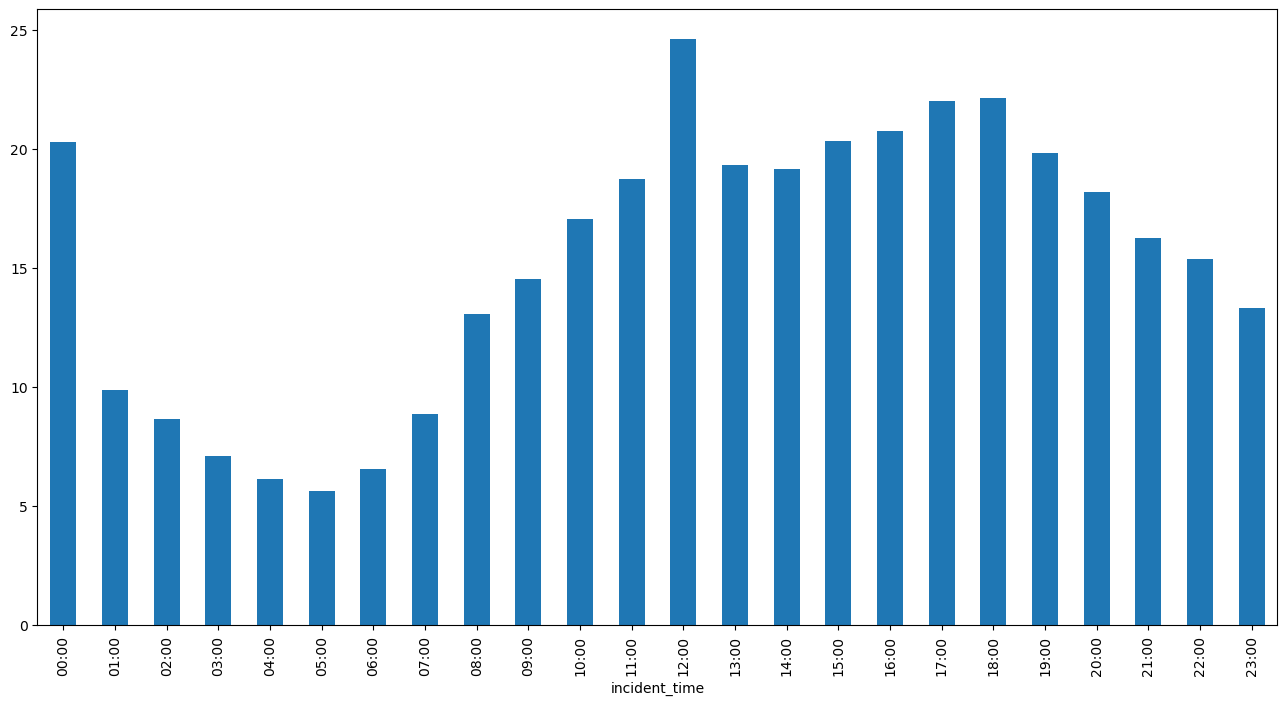

In [45]:
Grouped_SF["crime count"].groupby(Grouped_SF["incident_time"]).mean().plot(figsize=(16,8),kind="bar")

### Hourly Trend Chicago

<Axes: xlabel='incident_time'>

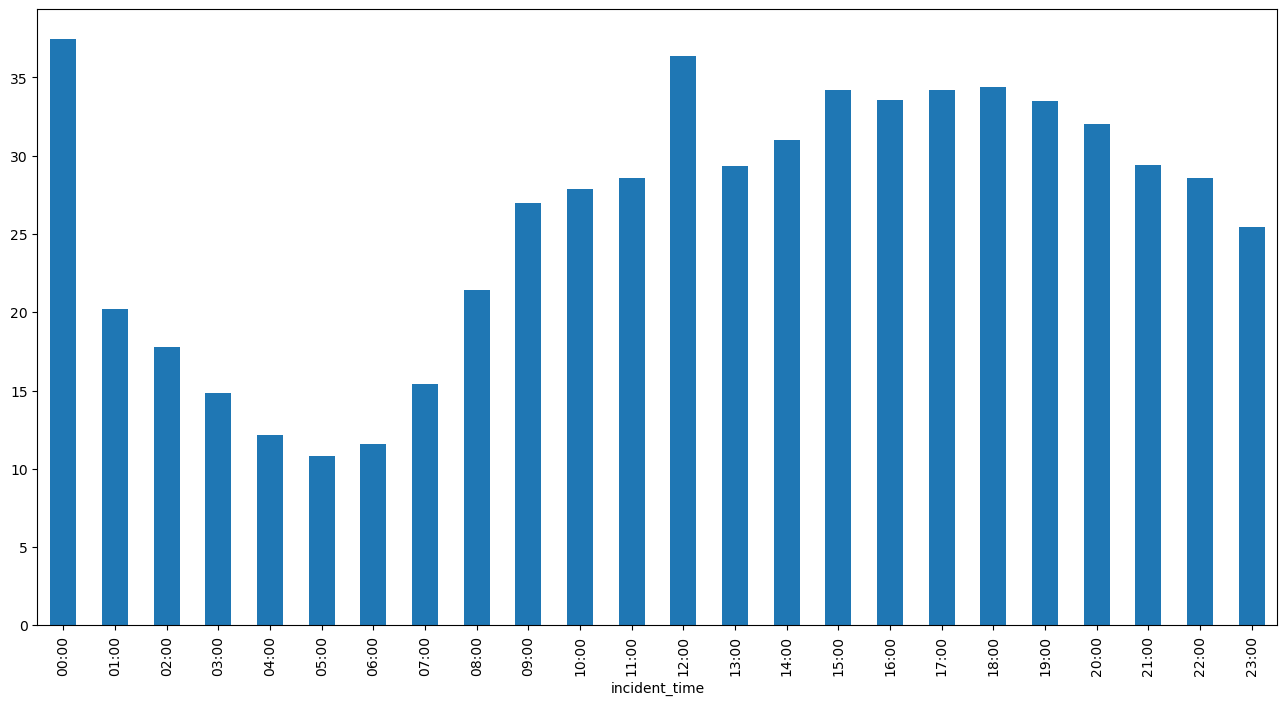

In [127]:
Grouped_Chicago["crime count"].groupby(Grouped_Chicago["incident_time"]).mean().plot(figsize=(16,8),kind="bar")

### Daily Trend SF

<Axes: xlabel='incident_day_of_week'>

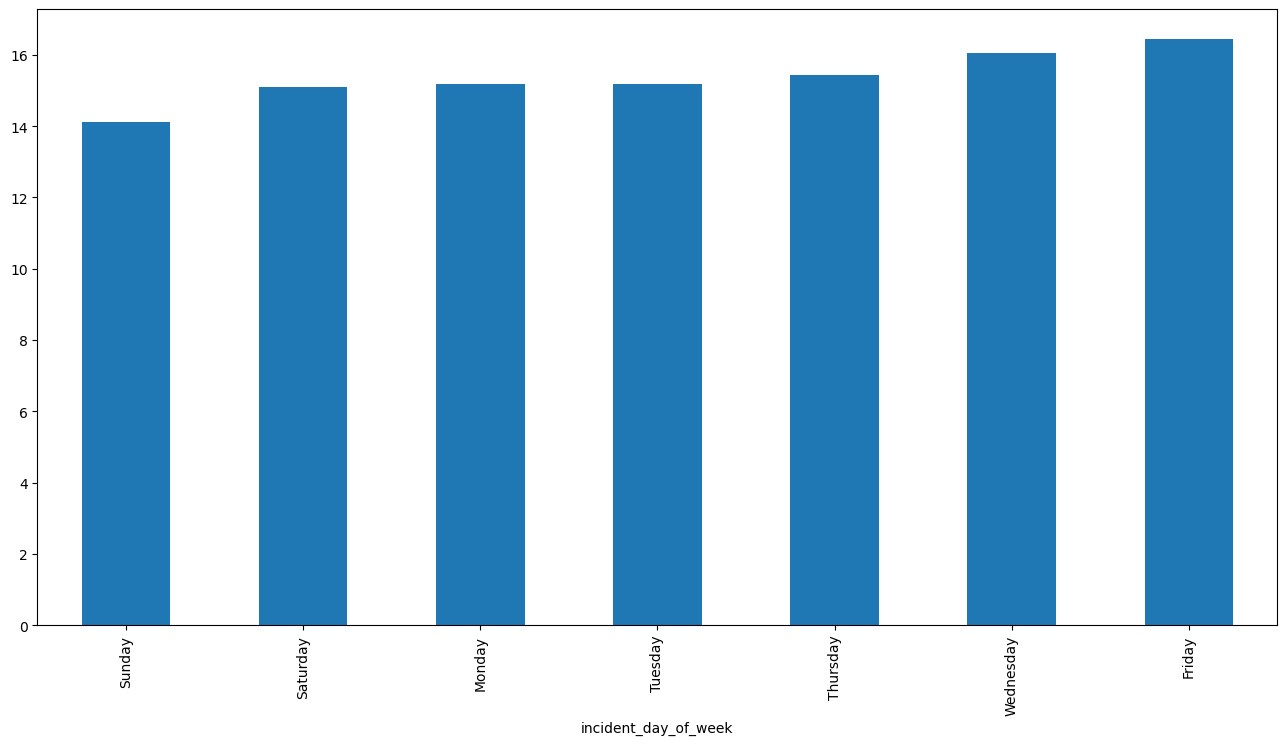

In [129]:
Grouped_SF["crime count"].groupby(Grouped_SF["incident_day_of_week"]).mean().sort_values().plot(figsize=(16,8),kind="bar")

### Daily Trend Chicago

<Axes: xlabel='incident_day_of_week'>

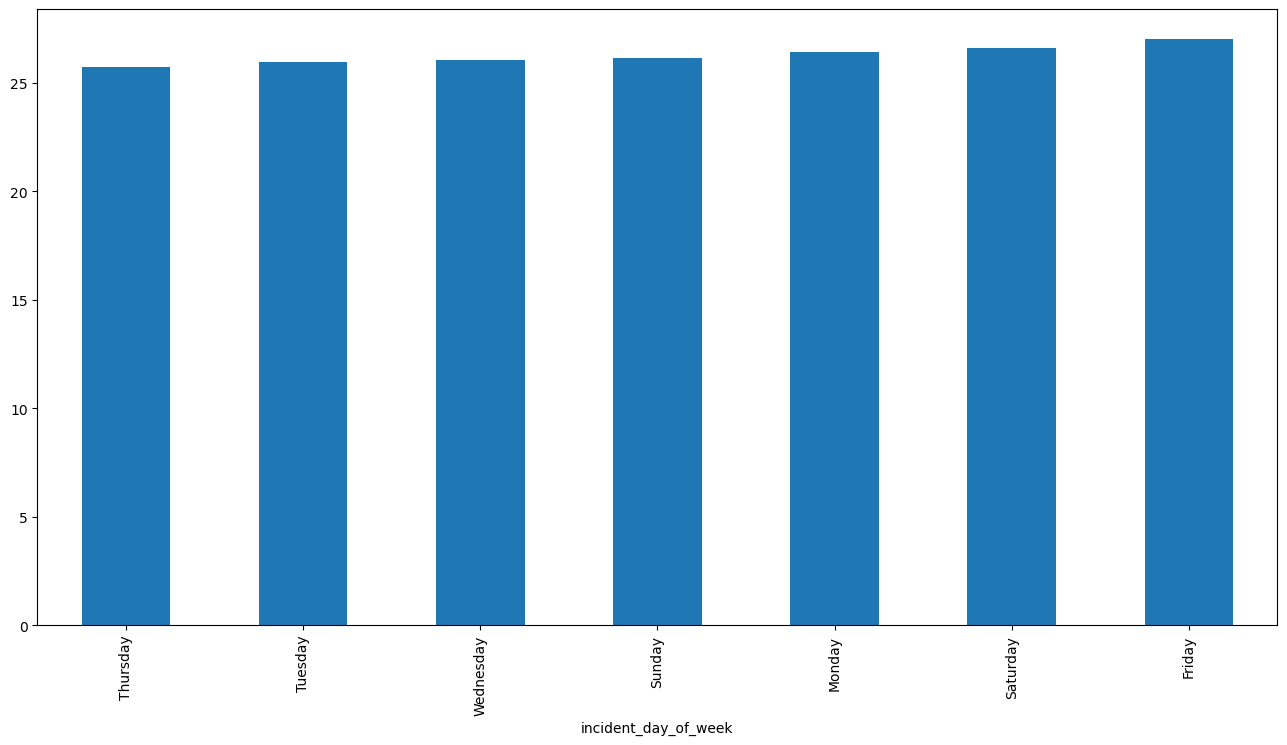

In [128]:
Grouped_Chicago["crime count"].groupby(Grouped_Chicago["incident_day_of_week"]).mean().sort_values().plot(figsize=(16,8),kind="bar")

### Monthly Trend SF

<Axes: xlabel='Month'>

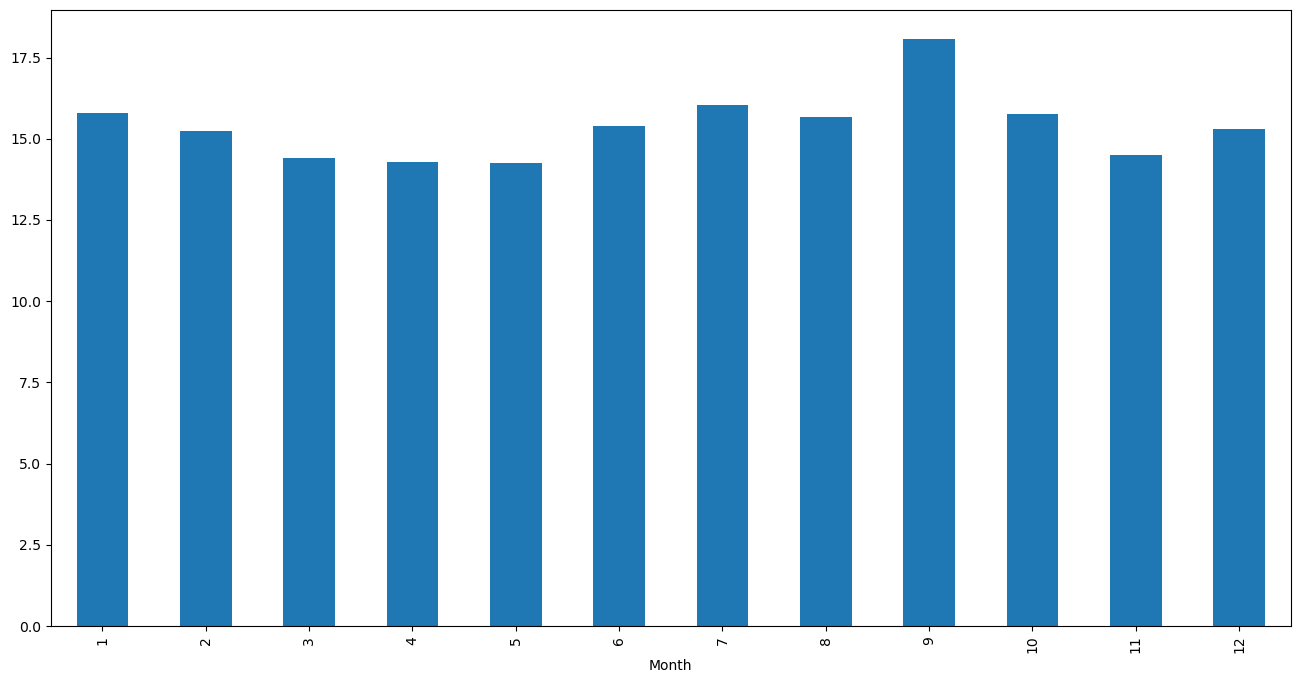

In [52]:
Grouped_SF["crime count"].groupby(Grouped_SF["Month"]).mean().sort_index().plot(figsize=(16,8),kind="bar")

### Monthly Trend Chicago

<Axes: xlabel='Month'>

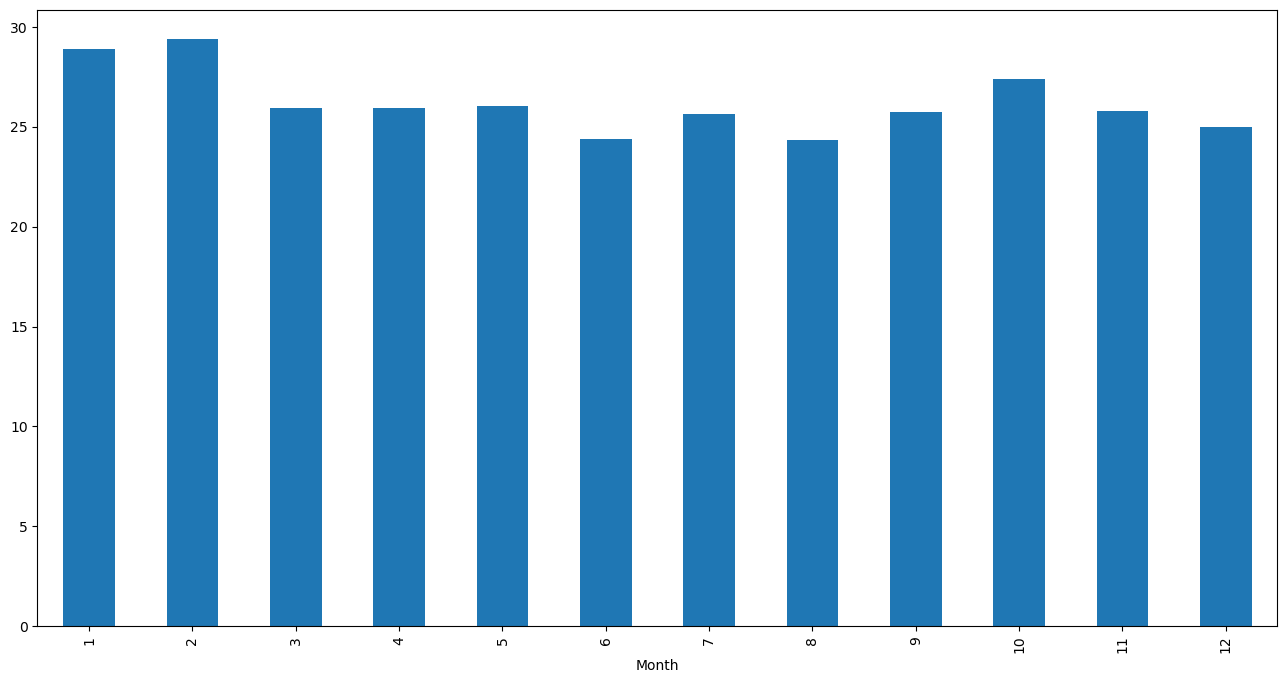

In [130]:
Grouped_Chicago["crime count"].groupby(Grouped_Chicago["Month"]).mean().sort_index().plot(figsize=(16,8),kind="bar")

## Cleaning the Weather Data 


In [53]:
def clean_the_weather(df):

    df['valid'] = pd.to_datetime(df['valid'])

    df['date'] = df['valid'].dt.date
    df['time'] = df['valid'].dt.time

    df["date"]=pd.to_datetime(df["date"])
    df.drop(["valid", "station"], axis=1, inplace=True)
    df['time'] = pd.to_datetime(df['time'], format='%H:%M:%S')



    df['rounded_time'] = df['time'] + pd.to_timedelta(30, unit='T')  
    df['rounded_time'] = df['rounded_time'].dt.strftime('%H:%M')
    df['rounded_time'] = df['rounded_time'].str.split(':').str[0] + ':00'
    df.drop(["time"],axis=1,inplace=True)
    df['date'] = df.apply(lambda row: row['date'] + pd.DateOffset(days=1) if row['rounded_time'] == '00:00' else row['date'], axis=1)
    return df


### Cleaning and Merging the Weather Data (Temperature) for SF

In [54]:
clean_the_weather(SF_TEMP)

KeyError: 'valid'

In [26]:
merged_df_SF=pd.merge(Grouped_SF,SF_TEMP,left_on=["incident_datetime","incident_time"],right_on=["date","rounded_time"])

In [27]:
merged_df_SF

,incident_datetime,incident_time,incident_year,incident_day_of_week,Month,crime count,tmpc,date,rounded_time
0,2018-01-01,01:00,2018,Monday,1,29,11.11,2018-01-01,01:00
1,2018-01-01,02:00,2018,Monday,1,23,10.56,2018-01-01,02:00
2,2018-01-01,03:00,2018,Monday,1,15,8.89,2018-01-01,03:00
3,2018-01-01,04:00,2018,Monday,1,8,8.33,2018-01-01,04:00
4,2018-01-01,05:00,2018,Monday,1,10,8.33,2018-01-01,05:00
...,...,...,...,...,...,...,...,...,...
54434,2024-04-07,20:00,2024,Sunday,4,11,12.22,2024-04-07,20:00
54435,2024-04-07,21:00,2024,Sunday,4,8,11.67,2024-04-07,21:00
54436,2024-04-07,22:00,2024,Sunday,4,16,11.67,2024-04-07,22:00
54437,2024-04-07,23:00,2024,Sunday,4,8,11.11,2024-04-07,23:00


### Cleaning and Merging the Weather Data (Temperature) for Chicago

In [131]:
clean_the_weather(Chicago_Temp)

,tmpc,date,rounded_time
0,-18.28,2018-01-01,01:00
1,-18.89,2018-01-01,02:00
2,-19.44,2018-01-01,03:00
3,-20.00,2018-01-01,04:00
4,-20.56,2018-01-01,05:00
...,...,...,...
54872,10.56,2024-04-07,20:00
54873,10.56,2024-04-07,21:00
54874,10.00,2024-04-07,22:00
54875,10.00,2024-04-07,23:00


In [134]:
merged_df_Chicago=pd.merge(Grouped_Chicago,Chicago_Temp,left_on=["date","incident_time"],right_on=["date","rounded_time"])

In [135]:
merged_df_Chicago

,date,incident_time,incident_year,incident_day_of_week,Month,crime count,tmpc,rounded_time
0,2018-01-01,01:00,2018,Monday,1,79,-18.28,01:00
1,2018-01-01,02:00,2018,Monday,1,74,-18.89,02:00
2,2018-01-01,03:00,2018,Monday,1,60,-19.44,03:00
3,2018-01-01,04:00,2018,Monday,1,31,-20.00,04:00
4,2018-01-01,05:00,2018,Monday,1,32,-20.56,05:00
...,...,...,...,...,...,...,...,...
51548,2024-04-07,20:00,2024,Sunday,4,48,10.56,20:00
51549,2024-04-07,21:00,2024,Sunday,4,42,10.56,21:00
51550,2024-04-07,22:00,2024,Sunday,4,44,10.00,22:00
51551,2024-04-07,23:00,2024,Sunday,4,52,10.00,23:00


### Cleaning and Merging the Weather Data (Precipitation) for SF

In [28]:
clean_the_weather(SF_PREC)

,p01m,date,rounded_time
0,0.00,2018-01-01,01:00
1,0.00,2018-01-01,02:00
2,0.00,2018-01-01,03:00
3,0.00,2018-01-01,04:00
4,0.00,2018-01-01,05:00
...,...,...,...
54833,0.00,2024-04-07,20:00
54834,0.00,2024-04-07,21:00
54835,0.00,2024-04-07,22:00
54836,0.00,2024-04-07,23:00


In [29]:
merged_df_SF2=pd.merge(merged_df_SF,SF_PREC,left_on=["incident_datetime","incident_time"],right_on=["date","rounded_time"])

In [30]:
merged_df_SF2

,incident_datetime,incident_time,incident_year,incident_day_of_week,Month,crime count,tmpc,date_x,rounded_time_x,p01m,date_y,rounded_time_y
0,2018-01-01,01:00,2018,Monday,1,29,11.11,2018-01-01,01:00,0.00,2018-01-01,01:00
1,2018-01-01,02:00,2018,Monday,1,23,10.56,2018-01-01,02:00,0.00,2018-01-01,02:00
2,2018-01-01,03:00,2018,Monday,1,15,8.89,2018-01-01,03:00,0.00,2018-01-01,03:00
3,2018-01-01,04:00,2018,Monday,1,8,8.33,2018-01-01,04:00,0.00,2018-01-01,04:00
4,2018-01-01,05:00,2018,Monday,1,10,8.33,2018-01-01,05:00,0.00,2018-01-01,05:00
...,...,...,...,...,...,...,...,...,...,...,...,...
54450,2024-04-07,20:00,2024,Sunday,4,11,12.22,2024-04-07,20:00,0.00,2024-04-07,20:00
54451,2024-04-07,21:00,2024,Sunday,4,8,11.67,2024-04-07,21:00,0.00,2024-04-07,21:00
54452,2024-04-07,22:00,2024,Sunday,4,16,11.67,2024-04-07,22:00,0.00,2024-04-07,22:00
54453,2024-04-07,23:00,2024,Sunday,4,8,11.11,2024-04-07,23:00,0.00,2024-04-07,23:00


In [32]:
merged_SF2=merged_df_SF2[["incident_datetime","incident_time","incident_year","incident_day_of_week","Month","tmpc","p01m","crime count"]]
merged_SF2

,incident_datetime,incident_time,incident_year,incident_day_of_week,Month,tmpc,p01m,crime count
0,2018-01-01,01:00,2018,Monday,1,11.11,0.00,29
1,2018-01-01,02:00,2018,Monday,1,10.56,0.00,23
2,2018-01-01,03:00,2018,Monday,1,8.89,0.00,15
3,2018-01-01,04:00,2018,Monday,1,8.33,0.00,8
4,2018-01-01,05:00,2018,Monday,1,8.33,0.00,10
...,...,...,...,...,...,...,...,...
54450,2024-04-07,20:00,2024,Sunday,4,12.22,0.00,11
54451,2024-04-07,21:00,2024,Sunday,4,11.67,0.00,8
54452,2024-04-07,22:00,2024,Sunday,4,11.67,0.00,16
54453,2024-04-07,23:00,2024,Sunday,4,11.11,0.00,8


In [33]:
merged_SF2["p01m"]=merged_SF2["p01m"].apply(lambda x: "0" if x=="0.00" else "1").copy()

C:\Users\erent\AppData\Local\Temp\ipykernel_14024\3371413882.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_SF2["p01m"]=merged_SF2["p01m"].apply(lambda x: "0" if x=="0.00" else "1").copy()


In [34]:
merged_SF2["p01m"]=merged_SF2["p01m"].astype(int)

C:\Users\erent\AppData\Local\Temp\ipykernel_14024\1976512933.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_SF2["p01m"]=merged_SF2["p01m"].astype(int)


In [55]:
merged_SF2

,incident_datetime,incident_time,incident_year,incident_day_of_week,Month,tmpc,p01m,crime count
0,2018-01-01,01:00,2018,Monday,1,11.11,0,29
1,2018-01-01,02:00,2018,Monday,1,10.56,0,23
2,2018-01-01,03:00,2018,Monday,1,8.89,0,15
3,2018-01-01,04:00,2018,Monday,1,8.33,0,8
4,2018-01-01,05:00,2018,Monday,1,8.33,0,10
...,...,...,...,...,...,...,...,...
54450,2024-04-07,20:00,2024,Sunday,4,12.22,0,11
54451,2024-04-07,21:00,2024,Sunday,4,11.67,0,8
54452,2024-04-07,22:00,2024,Sunday,4,11.67,0,16
54453,2024-04-07,23:00,2024,Sunday,4,11.11,0,8


### Cleaning and Merging the Weather Data (Precipitation) for Chicago

In [136]:
clean_the_weather(Chicago_Prec)

,p01m,date,rounded_time
0,0.00,2018-01-01,01:00
1,0.00,2018-01-01,02:00
2,0.00,2018-01-01,03:00
3,0.00,2018-01-01,04:00
4,0.00,2018-01-01,05:00
...,...,...,...
54872,0.00,2024-04-07,20:00
54873,0.00,2024-04-07,21:00
54874,0.00,2024-04-07,22:00
54875,0.00,2024-04-07,23:00


In [137]:
merged_df_Chicago2=pd.merge(merged_df_Chicago,Chicago_Prec,left_on=["date","incident_time"],right_on=["date","rounded_time"])

In [138]:
merged_Chicago2=merged_df_Chicago2[["date","incident_time","incident_year","incident_day_of_week","Month","tmpc","p01m","crime count"]]
merged_Chicago2

,date,incident_time,incident_year,incident_day_of_week,Month,tmpc,p01m,crime count
0,2018-01-01,01:00,2018,Monday,1,-18.28,0.00,79
1,2018-01-01,02:00,2018,Monday,1,-18.89,0.00,74
2,2018-01-01,03:00,2018,Monday,1,-19.44,0.00,60
3,2018-01-01,04:00,2018,Monday,1,-20.00,0.00,31
4,2018-01-01,05:00,2018,Monday,1,-20.56,0.00,32
...,...,...,...,...,...,...,...,...
51560,2024-04-07,20:00,2024,Sunday,4,10.56,0.00,48
51561,2024-04-07,21:00,2024,Sunday,4,10.56,0.00,42
51562,2024-04-07,22:00,2024,Sunday,4,10.00,0.00,44
51563,2024-04-07,23:00,2024,Sunday,4,10.00,0.00,52


In [139]:
merged_Chicago2["p01m"]=merged_Chicago2["p01m"].apply(lambda x: "0" if x=="0.00" else "1").copy()
merged_Chicago2["p01m"]=merged_Chicago2["p01m"].astype(int)

C:\Users\erent\AppData\Local\Temp\ipykernel_14024\3023811575.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_Chicago2["p01m"]=merged_Chicago2["p01m"].apply(lambda x: "0" if x=="0.00" else "1").copy()
C:\Users\erent\AppData\Local\Temp\ipykernel_14024\3023811575.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_SF2["p01m"]=merged_SF2["p01m"].astype(int)


In [141]:
merged_Chicago2

,date,incident_time,incident_year,incident_day_of_week,Month,tmpc,p01m,crime count
0,2018-01-01,01:00,2018,Monday,1,-18.28,0,79
1,2018-01-01,02:00,2018,Monday,1,-18.89,0,74
2,2018-01-01,03:00,2018,Monday,1,-19.44,0,60
3,2018-01-01,04:00,2018,Monday,1,-20.00,0,31
4,2018-01-01,05:00,2018,Monday,1,-20.56,0,32
...,...,...,...,...,...,...,...,...
51560,2024-04-07,20:00,2024,Sunday,4,10.56,0,48
51561,2024-04-07,21:00,2024,Sunday,4,10.56,0,42
51562,2024-04-07,22:00,2024,Sunday,4,10.00,0,44
51563,2024-04-07,23:00,2024,Sunday,4,10.00,0,52


### Cleaning the Full Moon Dataset

In [56]:
full_moon_df

,day,month,phase,time,year
0,2,1,Full Moon,02:24,2018
1,31,1,Full Moon,13:27,2018
2,2,3,Full Moon,00:51,2018
3,31,3,Full Moon,12:37,2018
4,30,4,Full Moon,00:58,2018
...,...,...,...,...,...
82,19,8,Full Moon,18:26,2024
83,18,9,Full Moon,02:34,2024
84,17,10,Full Moon,11:26,2024
85,15,11,Full Moon,21:28,2024


In [57]:
full_moon_df['date'] = pd.to_datetime(full_moon_df[['day', 'month', 'year']])
full_moon_df['date'] = full_moon_df['date'].dt.strftime('%Y-%m-%d')
full_moon_df.drop(['day', 'month', 'year'], axis=1, inplace=True)

In [58]:
full_moon_df

,phase,time,date
0,Full Moon,02:24,2018-01-02
1,Full Moon,13:27,2018-01-31
2,Full Moon,00:51,2018-03-02
3,Full Moon,12:37,2018-03-31
4,Full Moon,00:58,2018-04-30
...,...,...,...
82,Full Moon,18:26,2024-08-19
83,Full Moon,02:34,2024-09-18
84,Full Moon,11:26,2024-10-17
85,Full Moon,21:28,2024-11-15


In [59]:
full_moon_df["date"]=pd.to_datetime(full_moon_df["date"])

### Merging the Full Moon Dataset with SF Data, Preproccesing

In [60]:
merged_SF_3=pd.merge(merged_SF2,full_moon_df,left_on=["incident_datetime"],right_on=["date"],how="left")

In [61]:
merged_SF_3['Full Moon'] = merged_SF_3.apply(lambda x: 1 if x['phase'] == 'Full Moon' else 0, axis=1)

In [62]:
merged_SF_3.drop(columns={"phase","time","date"},inplace=True)
merged_SF_3

,incident_datetime,incident_time,incident_year,incident_day_of_week,Month,tmpc,p01m,crime count,Full Moon
0,2018-01-01,01:00,2018,Monday,1,11.11,0,29,0
1,2018-01-01,02:00,2018,Monday,1,10.56,0,23,0
2,2018-01-01,03:00,2018,Monday,1,8.89,0,15,0
3,2018-01-01,04:00,2018,Monday,1,8.33,0,8,0
4,2018-01-01,05:00,2018,Monday,1,8.33,0,10,0
...,...,...,...,...,...,...,...,...,...
54450,2024-04-07,20:00,2024,Sunday,4,12.22,0,11,0
54451,2024-04-07,21:00,2024,Sunday,4,11.67,0,8,0
54452,2024-04-07,22:00,2024,Sunday,4,11.67,0,16,0
54453,2024-04-07,23:00,2024,Sunday,4,11.11,0,8,0


In [63]:
merged_SF_3[merged_SF_3["Full Moon"]==1]

,incident_datetime,incident_time,incident_year,incident_day_of_week,Month,tmpc,p01m,crime count,Full Moon
23,2018-01-02,00:00,2018,Tuesday,1,11.67,0,15,1
24,2018-01-02,01:00,2018,Tuesday,1,11.67,0,4,1
25,2018-01-02,02:00,2018,Tuesday,1,10.56,0,1,1
26,2018-01-02,03:00,2018,Tuesday,1,10.00,0,6,1
27,2018-01-02,04:00,2018,Tuesday,1,10.00,0,3,1
...,...,...,...,...,...,...,...,...,...
54138,2024-03-25,19:00,2024,Monday,3,12.78,0,12,1
54139,2024-03-25,20:00,2024,Monday,3,12.22,0,21,1
54140,2024-03-25,21:00,2024,Monday,3,12.22,0,14,1
54141,2024-03-25,22:00,2024,Monday,3,12.22,0,9,1


### Merging the Full Moon Dataset with Chicago Data, Preproccesing


In [188]:
merged_Chicago_3=pd.merge(merged_Chicago2,full_moon_df,left_on=["date"],right_on=["date"],how="left")
merged_Chicago_3['Full Moon'] = merged_Chicago_3.apply(lambda x: 1 if x['phase'] == 'Full Moon' else 0, axis=1)
merged_Chicago_3.drop(columns={"phase","time"},inplace=True)
merged_Chicago_3

,date,incident_time,incident_year,incident_day_of_week,Month,tmpc,p01m,crime count,Full Moon
0,2018-01-01,01:00,2018,Monday,1,-18.28,0,79,0
1,2018-01-01,02:00,2018,Monday,1,-18.89,0,74,0
2,2018-01-01,03:00,2018,Monday,1,-19.44,0,60,0
3,2018-01-01,04:00,2018,Monday,1,-20.00,0,31,0
4,2018-01-01,05:00,2018,Monday,1,-20.56,0,32,0
...,...,...,...,...,...,...,...,...,...
51560,2024-04-07,20:00,2024,Sunday,4,10.56,0,48,0
51561,2024-04-07,21:00,2024,Sunday,4,10.56,0,42,0
51562,2024-04-07,22:00,2024,Sunday,4,10.00,0,44,0
51563,2024-04-07,23:00,2024,Sunday,4,10.00,0,52,0


In [189]:
merged_Chicago_3[merged_Chicago_3["Full Moon"]==1]

,date,incident_time,incident_year,incident_day_of_week,Month,tmpc,p01m,crime count,Full Moon
23,2018-01-02,00:00,2018,Tuesday,1,-20.56,0,39,1
24,2018-01-02,01:00,2018,Tuesday,1,-20.56,0,10,1
25,2018-01-02,02:00,2018,Tuesday,1,-21.11,0,22,1
26,2018-01-02,03:00,2018,Tuesday,1,-21.67,0,12,1
27,2018-01-02,04:00,2018,Tuesday,1,-22.22,0,9,1
...,...,...,...,...,...,...,...,...,...
51244,2024-03-25,19:00,2024,Monday,3,17.22,1,80,1
51245,2024-03-25,20:00,2024,Monday,3,16.67,0,70,1
51246,2024-03-25,21:00,2024,Monday,3,17.22,0,68,1
51247,2024-03-25,22:00,2024,Monday,3,14.44,1,48,1


## Is Crime Count Associated with Full Moon?
### San Fransico Incidents and Full Moon (Statistical Analysis)

In [65]:
merged_SF_3

,incident_datetime,incident_time,incident_year,incident_day_of_week,Month,tmpc,p01m,crime count,Full Moon
0,2018-01-01,01:00,2018,Monday,1,11.11,0,29,0
1,2018-01-01,02:00,2018,Monday,1,10.56,0,23,0
2,2018-01-01,03:00,2018,Monday,1,8.89,0,15,0
3,2018-01-01,04:00,2018,Monday,1,8.33,0,8,0
4,2018-01-01,05:00,2018,Monday,1,8.33,0,10,0
...,...,...,...,...,...,...,...,...,...
54450,2024-04-07,20:00,2024,Sunday,4,12.22,0,11,0
54451,2024-04-07,21:00,2024,Sunday,4,11.67,0,8,0
54452,2024-04-07,22:00,2024,Sunday,4,11.67,0,16,0
54453,2024-04-07,23:00,2024,Sunday,4,11.11,0,8,0


To check whether there is an association, I will compare two group means. One of them will be the days with Full Moon and the other will be the days without it. I will perform independent two group t-test to find a p-value. Since I will take the whole day as a "Full Moon" day. I will group my frame by days first.

In [66]:
Full_moondf_SF=merged_SF_3[["incident_datetime","crime count","Full Moon"]].groupby("incident_datetime").agg({"crime count":"sum","Full Moon":"first"}).reset_index()
Full_moondf_SF                                           

,incident_datetime,crime count,Full Moon
0,2018-01-01,434,0
1,2018-01-02,393,1
2,2018-01-03,426,0
3,2018-01-04,468,0
4,2018-01-05,442,0
...,...,...,...
2285,2024-04-04,295,0
2286,2024-04-05,383,0
2287,2024-04-06,263,0
2288,2024-04-07,235,0


In [67]:
Full_moondf_SF.groupby(Full_moondf_SF["Full Moon"]).agg({"crime count":"mean","incident_datetime":"count"}).reset_index()

,Full Moon,crime count,incident_datetime
0,0,367.248192,2212
1,1,374.166667,78


In [151]:


crime_count_full_moon_sf = Full_moondf_SF[Full_moondf_SF['Full Moon'] == 1]['crime count']
crime_count_non_full_moon_sf = Full_moondf_SF[Full_moondf_SF['Full Moon'] == 0]['crime count']


t_statistic, p_value = ttest_ind(crime_count_full_moon_sf, crime_count_non_full_moon_sf)


print("Two-sample t-test statistic:", t_statistic)
print("P-value:", p_value)

Two-sample t-test statistic: 0.7329151656941295
P-value: 0.4636852514648415


In [152]:


U_statistic, p_value = mannwhitneyu(crime_count_full_moon_sf, crime_count_non_full_moon_sf)

 
print("Mann-Whitney U test statistic:", U_statistic)
print("P-value:", p_value)

Mann-Whitney U test statistic: 90373.0
P-value: 0.4745084177259733


### Chicago Incidents and Full Moon (Statistical Analysis)

In [149]:
Full_moondf_Chicago=merged_Chicago_3[["date","crime count","Full Moon"]].groupby("date").agg({"crime count":"sum","Full Moon":"first"}).reset_index()
Full_moondf_Chicago

,date,crime count,Full Moon
0,2018-01-01,1067,0
1,2018-01-02,952,1
2,2018-01-03,997,0
3,2018-01-04,1031,0
4,2018-01-05,1172,0
...,...,...,...
2285,2024-04-04,1220,0
2286,2024-04-05,1286,0
2287,2024-04-06,1394,0
2288,2024-04-07,1222,0


In [150]:
Full_moondf_Chicago.groupby(Full_moondf_Chicago["Full Moon"]).agg({"crime count":"mean","date":"count"}).reset_index()

,Full Moon,crime count,date
0,0,579.165009,2212
1,1,583.423077,78


In [153]:

crime_count_full_moon_chicago = Full_moondf_Chicago[Full_moondf_Chicago['Full Moon'] == 1]['crime count']
crime_count_non_full_moon_chicago = Full_moondf_Chicago[Full_moondf_Chicago['Full Moon'] == 0]['crime count']


t_statistic, p_value = ttest_ind(crime_count_full_moon_chicago, crime_count_non_full_moon_chicago)


print("Two-sample t-test statistic:", t_statistic)
print("P-value:", p_value)

Two-sample t-test statistic: 0.10679026935974605
P-value: 0.9149647295036797


In [154]:

U_statistic, p_value = mannwhitneyu(crime_count_full_moon_chicago, crime_count_non_full_moon_chicago)

 
print("Mann-Whitney U test statistic:", U_statistic)
print("P-value:", p_value)

Mann-Whitney U test statistic: 86997.5
P-value: 0.8989258677220644


## Is Crime Count Associated with Precipitation?
### San Fransisco Incidents and Hourly Precipitation 

In [168]:
cross_tab_mean_sf = pd.crosstab(index=merged_SF_3['incident_time'], columns=merged_SF_3['p01m'].map({0: 'No Rain', 1: 'Rain'}), values=merged_SF_3['crime count'], aggfunc='mean')


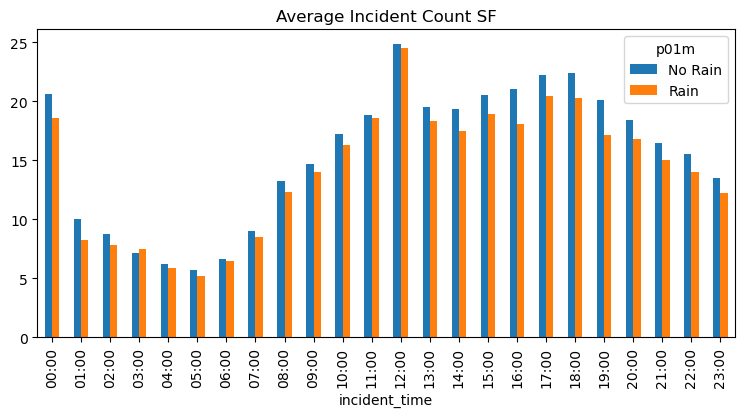

In [169]:
gra=cross_tab_mean_sf.plot(kind='bar', stacked=False,figsize=(9,4))
gra.set_title("Average Incident Count SF")

plt.show()

In [72]:
Stat_SF_prec=merged_SF_3[["incident_time","crime count","p01m"]].copy()

In [73]:
Stat_SF_prec_with_rain=Stat_SF_prec[Stat_SF_prec["p01m"]==1]
Stat_SF_prec_without_rain=Stat_SF_prec[Stat_SF_prec["p01m"]==0]

In [76]:
def compare_hourly_statistics_crime_counts(data_with_rain, data_without_rain):
    hourly_results = {}
    hours = ["{:02d}:00".format(hour) for hour in range(24)]
    
    for hour in hours:
        crime_count_with_rain = data_with_rain[data_with_rain["incident_time"] == hour]["crime count"]
        crime_count_without_rain = data_without_rain[data_without_rain["incident_time"] == hour]["crime count"]
        
        t_statistic, p_value = ttest_ind(crime_count_with_rain, crime_count_without_rain)
        
        hourly_results[hour] = {"t_statistic": t_statistic, "p_value": p_value}
    
    return hourly_results




In [77]:
hourly_comparison_sf_rain = compare_hourly_statistics_crime_counts(Stat_SF_prec_with_rain, Stat_SF_prec_without_rain)

In [78]:
pd.DataFrame(hourly_comparison_sf_rain).T

,t_statistic,p_value
00:00,-2.465192,0.013767
01:00,-4.174625,0.000031
02:00,-2.277430,0.022853
03:00,0.991879,0.321364
04:00,-1.010249,0.312486
05:00,-1.971927,0.048742
06:00,-0.512646,0.608249
07:00,-1.310695,0.190094
08:00,-1.860593,0.062931
09:00,-1.348479,0.177639


### Chicago Incidents and Hourly Precipitation 

In [166]:
cross_tab_mean_chicago = pd.crosstab(index=merged_Chicago_3['incident_time'], columns=merged_Chicago_3['p01m'].map({0: 'No Rain', 1: 'Rain'}), values=merged_Chicago_3['crime count'], aggfunc='mean')


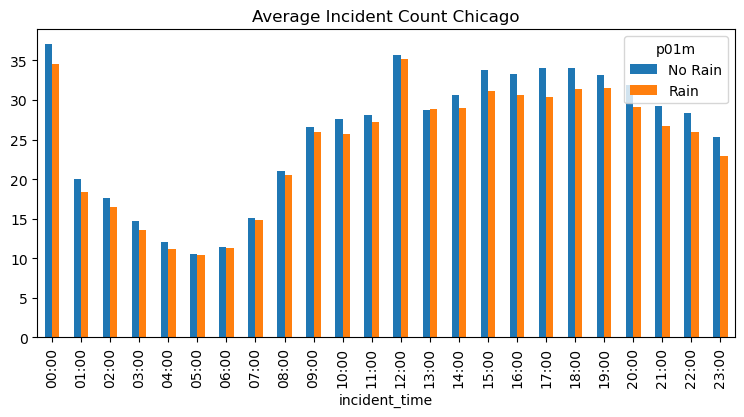

In [167]:
gra=cross_tab_mean_chicago.plot(kind='bar', stacked=False,figsize=(9,4))
gra.set_title("Average Incident Count Chicago")

plt.show()

In [161]:
Stat_Chicago_prec=merged_Chicago_3[["incident_time","crime count","p01m"]].copy()
Stat_Chicago_prec_with_rain=Stat_Chicago_prec[Stat_Chicago_prec["p01m"]==1]
Stat_Chicago_prec_without_rain=Stat_Chicago_prec[Stat_Chicago_prec["p01m"]==0]

In [163]:
hourly_comparison_chicago_rain = compare_hourly_statistics_crime_counts(Stat_Chicago_prec_with_rain, Stat_Chicago_prec_without_rain)
pd.DataFrame(hourly_comparison_chicago_rain)

,00:00,01:00,02:00,03:00,04:00,05:00,06:00,07:00,08:00,09:00,...,14:00,15:00,16:00,17:00,18:00,19:00,20:00,21:00,22:00,23:00
t_statistic,-1.935148,-2.109310,-1.481939,-1.775659,-1.882766,-0.256166,-0.293376,-0.556419,-0.558028,-0.780481,...,-1.389173,-2.315004,-2.314729,-3.211144,-2.307876,-1.353681,-2.582992,-2.686488,-2.571360,-2.842605
p_value,0.053098,0.035035,0.138505,0.075935,0.059872,0.797849,0.769264,0.577983,0.576883,0.435191,...,0.164923,0.020705,0.020721,0.001342,0.021101,0.175981,0.009860,0.007276,0.010197,0.004517


### Does crime count have an association with Daily Temperatures? - SF

In [335]:
merged_SF_3['tmpc'].fillna(method='ffill', inplace=True)


In [336]:
merged_SF_3[["tmpc","crime count"]].groupby(merged_SF_3["incident_datetime"]).agg({"tmpc":"mean","crime count":"sum"}).corr()

,tmpc,crime count
tmpc,1.000000,0.076807
crime count,0.076807,1.000000


### Does crime count have an association with Daily Temperatures? - Chicago

In [190]:
merged_Chicago_3['tmpc'].replace('M', np.nan, inplace=True)

merged_Chicago_3['tmpc'].fillna(method='ffill', inplace=True)

merged_Chicago_3['tmpc'] = merged_Chicago_3['tmpc'].astype(float)

In [191]:
merged_Chicago_3[["tmpc","crime count"]].groupby(merged_Chicago_3["date"]).agg({"tmpc":"mean","crime count":"sum"}).corr()

,tmpc,crime count
tmpc,1.000000,-0.032825
crime count,-0.032825,1.000000


## How does the Incident Count Change during Public Holidays?

In [197]:
us_holidays = []

for year in range(2018, 2025):
    holidays_for_year = getattr(holidays.UnitedStates(years=year), 'items')()
    
    us_holidays.extend(holidays_for_year)

holiday_df = pd.DataFrame(us_holidays, columns=['Date', 'Holiday'])


In [211]:
holiday_df["Date"]=pd.to_datetime(holiday_df["Date"])

In [203]:
holiday_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     84 non-null     datetime64[ns]
 1   Holiday  84 non-null     object        
dtypes: datetime64[ns](1), object(1)
memory usage: 1.4+ KB


### SF on Public Holidays

In [337]:
merged_SF4=pd.merge(merged_SF_3,holiday_df,left_on=["incident_datetime"],right_on=["Date"],how="left")

In [338]:
grouped_for_holidays_sf=merged_SF4[["crime count","Holiday"]].groupby(merged_SF4["incident_datetime"]).agg({"crime count":"sum","Holiday":"first"}).copy().reset_index()
grouped_for_holidays_sf

,incident_datetime,crime count,Holiday
0,2018-01-01,434,New Year's Day
1,2018-01-02,393,None
2,2018-01-03,426,None
3,2018-01-04,468,None
4,2018-01-05,442,None
...,...,...,...
2285,2024-04-04,295,None
2286,2024-04-05,383,None
2287,2024-04-06,263,None
2288,2024-04-07,235,None


In [339]:
grouped_for_holidays_sf["crime count"].groupby(grouped_for_holidays_sf["Holiday"]).mean().sort_values()

Holiday
Veterans Day (observed)                            224.000000
Thanksgiving                                       230.333333
Christmas Day                                      255.666667
Christmas Day (observed)                           309.000000
Veterans Day                                       317.833333
Juneteenth National Independence Day               330.333333
New Year's Day (observed)                          332.500000
Martin Luther King Jr. Day                         342.285714
Memorial Day                                       350.333333
Independence Day                                   356.166667
Washington's Birthday                              358.285714
Columbus Day                                       375.166667
Independence Day (observed)                        378.500000
Juneteenth National Independence Day (observed)    428.000000
Labor Day                                          435.666667
New Year's Day                                     520.142857


In [340]:
merged_SF4.drop("Date", axis=1, inplace=True)


In [341]:

merged_SF4["Holiday"] = merged_SF4["Holiday"].fillna(0).apply(lambda x: 1 if x != 0 else 0)
merged_SF4

,incident_datetime,incident_time,incident_year,incident_day_of_week,Month,tmpc,p01m,crime count,Full Moon,Holiday
0,2018-01-01,01:00,2018,Monday,1,11.11,0,29,0,1
1,2018-01-01,02:00,2018,Monday,1,10.56,0,23,0,1
2,2018-01-01,03:00,2018,Monday,1,8.89,0,15,0,1
3,2018-01-01,04:00,2018,Monday,1,8.33,0,8,0,1
4,2018-01-01,05:00,2018,Monday,1,8.33,0,10,0,1
...,...,...,...,...,...,...,...,...,...,...
54450,2024-04-07,20:00,2024,Sunday,4,12.22,0,11,0,0
54451,2024-04-07,21:00,2024,Sunday,4,11.67,0,8,0,0
54452,2024-04-07,22:00,2024,Sunday,4,11.67,0,16,0,0
54453,2024-04-07,23:00,2024,Sunday,4,11.11,0,8,0,0


In [342]:
holiday_df_SF=merged_SF4[["incident_datetime","crime count","Holiday"]].groupby("incident_datetime").agg({"crime count":"sum","Holiday":"first"}).reset_index()
holiday_df_SF.groupby(holiday_df_SF["Holiday"]).agg({"crime count":"mean","incident_datetime":"count"}).reset_index()

,Holiday,crime count,incident_datetime
0,0,367.990515,2214
1,1,352.723684,76


In [343]:

crime_count_holiday_sf = holiday_df_SF[holiday_df_SF['Holiday'] == 1]['crime count']
crime_count_no_holiday_sf = holiday_df_SF[holiday_df_SF['Holiday'] == 0]['crime count']


t_statistic, p_value = ttest_ind(crime_count_holiday_sf, crime_count_no_holiday_sf)


print("Two-sample t-test statistic:", t_statistic)
print("P-value:", p_value)


Two-sample t-test statistic: -1.5978616285954443
P-value: 0.11021185849181993


In [344]:

U_statistic, p_value = mannwhitneyu(crime_count_holiday_sf, crime_count_no_holiday_sf)

 
print("Mann-Whitney U test statistic:", U_statistic)
print("P-value:", p_value)

Mann-Whitney U test statistic: 74531.5
P-value: 0.09030473754612768


### Chicago on Public Holidays

In [280]:
merged_Chicago_4=pd.merge(merged_Chicago_3,holiday_df,left_on=["date"],right_on=["Date"],how="left")
grouped_for_holidays_chicago=merged_Chicago_4[["crime count","Holiday"]].groupby(merged_Chicago_4["date"]).agg({"crime count":"sum","Holiday":"first"}).copy().reset_index()
grouped_for_holidays_chicago

,date,crime count,Holiday
0,2018-01-01,1067,New Year's Day
1,2018-01-02,952,None
2,2018-01-03,997,None
3,2018-01-04,1031,None
4,2018-01-05,1172,None
...,...,...,...
2285,2024-04-04,1220,None
2286,2024-04-05,1286,None
2287,2024-04-06,1394,None
2288,2024-04-07,1222,None


In [283]:
grouped_for_holidays_chicago["crime count"].groupby(grouped_for_holidays_chicago["Holiday"]).mean().sort_values()

Holiday
Juneteenth National Independence Day (observed)    275.000000
Veterans Day (observed)                            375.500000
Christmas Day                                      404.666667
Thanksgiving                                       406.166667
Juneteenth National Independence Day               407.000000
Christmas Day (observed)                           439.500000
Independence Day (observed)                        487.500000
Veterans Day                                       497.666667
Labor Day                                          501.833333
New Year's Day (observed)                          555.500000
Columbus Day                                       561.666667
Memorial Day                                       571.333333
Martin Luther King Jr. Day                         588.714286
Independence Day                                   635.500000
Washington's Birthday                              707.285714
New Year's Day                                     856.714286


In [284]:
merged_Chicago_4

,date,incident_time,incident_year,incident_day_of_week,Month,tmpc,p01m,crime count,Full Moon,Date,Holiday
0,2018-01-01,01:00,2018,Monday,1,-18.28,0,79,0,2018-01-01,New Year's Day
1,2018-01-01,02:00,2018,Monday,1,-18.89,0,74,0,2018-01-01,New Year's Day
2,2018-01-01,03:00,2018,Monday,1,-19.44,0,60,0,2018-01-01,New Year's Day
3,2018-01-01,04:00,2018,Monday,1,-20.00,0,31,0,2018-01-01,New Year's Day
4,2018-01-01,05:00,2018,Monday,1,-20.56,0,32,0,2018-01-01,New Year's Day
...,...,...,...,...,...,...,...,...,...,...,...
51560,2024-04-07,20:00,2024,Sunday,4,10.56,0,48,0,NaT,NaN
51561,2024-04-07,21:00,2024,Sunday,4,10.56,0,42,0,NaT,NaN
51562,2024-04-07,22:00,2024,Sunday,4,10.00,0,44,0,NaT,NaN
51563,2024-04-07,23:00,2024,Sunday,4,10.00,0,52,0,NaT,NaN


In [285]:
merged_Chicago_4.drop("Date", axis=1, inplace=True)

merged_Chicago_4["Holiday"] = merged_Chicago_4["Holiday"].fillna(0).apply(lambda x: 1 if x != 0 else 0)
merged_Chicago_4

,date,incident_time,incident_year,incident_day_of_week,Month,tmpc,p01m,crime count,Full Moon,Holiday
0,2018-01-01,01:00,2018,Monday,1,-18.28,0,79,0,1
1,2018-01-01,02:00,2018,Monday,1,-18.89,0,74,0,1
2,2018-01-01,03:00,2018,Monday,1,-19.44,0,60,0,1
3,2018-01-01,04:00,2018,Monday,1,-20.00,0,31,0,1
4,2018-01-01,05:00,2018,Monday,1,-20.56,0,32,0,1
...,...,...,...,...,...,...,...,...,...,...
51560,2024-04-07,20:00,2024,Sunday,4,10.56,0,48,0,0
51561,2024-04-07,21:00,2024,Sunday,4,10.56,0,42,0,0
51562,2024-04-07,22:00,2024,Sunday,4,10.00,0,44,0,0
51563,2024-04-07,23:00,2024,Sunday,4,10.00,0,52,0,0


In [286]:
holiday_df_Chicago=merged_Chicago_4[["date","crime count","Holiday"]].groupby("date").agg({"crime count":"sum","Holiday":"first"}).reset_index()
holiday_df_Chicago.groupby(holiday_df_Chicago["Holiday"]).agg({"crime count":"mean","date":"count"}).reset_index()

,Holiday,crime count,date
0,0,580.212737,2214
1,1,553.013158,76


In [287]:
crime_count_holiday_chicago = holiday_df_Chicago[holiday_df_Chicago['Holiday'] == 1]['crime count']
crime_count_no_holiday_chicago = holiday_df_Chicago[holiday_df_Chicago['Holiday'] == 0]['crime count']


t_statistic, p_value = ttest_ind(crime_count_holiday_chicago, crime_count_no_holiday_chicago)


print("Two-sample t-test statistic:", t_statistic)
print("P-value:", p_value)


Two-sample t-test statistic: -0.6737193489049447
P-value: 0.5005578099002597


In [288]:
U_statistic, p_value = mannwhitneyu(crime_count_holiday_chicago, crime_count_no_holiday_chicago)

 
print("Mann-Whitney U test statistic:", U_statistic)
print("P-value:", p_value)

Mann-Whitney U test statistic: 80263.5
P-value: 0.4949555856342547


## Modeling to Predict Hourly Incident Counts

### Preproccesing the Datasets 
I will write a function to encode the neccesary columns and merge it with other features to have the final dataset, ready to be trained. I used one-hot encoding here for all my categorical columns. I had also tried cyclic encoding for the hour column but I didn't like my results. I dropped the first category of each feature when encoding, in order to ensure I don't have any trouble with multicollinearity due to that particular reason. This was a must, especially if I decided to train with linear regression. 

In [348]:
def encode_split_dataset(dataset):
    hour_dummies = pd.get_dummies(dataset['incident_time'], prefix='hour', drop_first=True)
    month_dummies = pd.get_dummies(dataset['Month'], prefix='month', drop_first=True)
    year_dummies = pd.get_dummies(dataset['incident_year'], prefix='year', drop_first=True)
    
    encoded_data = pd.concat([dataset[['tmpc', 'p01m', 'Full Moon', 'Holiday', 'crime count']], 
                              hour_dummies, month_dummies, year_dummies], axis=1)
    
    X = encoded_data.drop("crime count", axis=1)
    y = encoded_data["crime count"]
    
    return X, y


### Choosing the Right Stratification Method

Before I write my validation function, I wanted to decide on how I would perform the splitting of the validation set. I could have done it completely randomly however, I believe that this is not a good idea since my data has temporal dependencies. As I have shown before, the crime count(the target in my case) values are heavily dependant on the hour. That is why I believe it is more reasonable to keep the hour distribution similar in both test and the train set. This will also help ensuring both subsets to have similar distributions in terms of my target.  

After deciding on using "the hour" column to stratify, I also wanted to see whether there are temporal patterns in "the year" column. What I found was the fact that yearly changes can be considered significant on the "crime counts". Therefore, I also wanted to include this column as a second to "hour" in my stratification.  

Below, I performed what I was talking about. It was just to see how the distributions were correctly handled, I also used the very same spliting method in my modeling in the next section. This was only to asses the split. I used the Chicago Dataset for this example. 

In [350]:
X, y = encode_split_dataset(merged_Chicago_4)


hour = merged_Chicago_4['incident_time']
year = merged_Chicago_4['incident_year']

stratify_var = hour.astype(str) + '_' + year.astype(str)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=stratify_var, test_size=0.2, random_state=45)

hour_train = hour.iloc[X_train.index]
hour_test = hour.iloc[X_test.index]
year_train = year.iloc[X_train.index]
year_test = year.iloc[X_test.index]

train_hour_distribution = hour_train.value_counts(normalize=True)
test_hour_distribution = hour_test.value_counts(normalize=True)
train_year_distribution = year_train.value_counts(normalize=True)
test_year_distribution = year_test.value_counts(normalize=True)

print("Training set hour distribution:")
print(train_hour_distribution)
print("\nTest set hour distribution:")
print(test_hour_distribution)

print("\nTraining set year distribution:")
print(train_year_distribution)
print("\nTest set year distribution:")
print(test_year_distribution)

Training set hour distribution:
incident_time
00:00    0.043489
12:00    0.043319
09:00    0.043125
10:00    0.042301
15:00    0.042204
13:00    0.042131
14:00    0.042131
16:00    0.041962
08:00    0.041937
17:00    0.041865
11:00    0.041840
21:00    0.041719
22:00    0.041695
20:00    0.041695
19:00    0.041646
18:00    0.041646
23:00    0.041210
02:00    0.041113
01:00    0.041016
07:00    0.041016
03:00    0.040507
06:00    0.040313
04:00    0.040168
05:00    0.039950
Name: proportion, dtype: float64

Test set hour distribution:
incident_time
00:00    0.043537
12:00    0.043343
09:00    0.043149
10:00    0.042374
14:00    0.042180
15:00    0.042180
13:00    0.042083
08:00    0.041986
16:00    0.041986
11:00    0.041889
17:00    0.041792
18:00    0.041695
22:00    0.041695
19:00    0.041598
21:00    0.041598
20:00    0.041598
23:00    0.041210
01:00    0.041113
07:00    0.041016
02:00    0.040919
03:00    0.040628
06:00    0.040337
04:00    0.040240
05:00    0.039853
Name: proporti

### Modeling and Validating the Model

I wanted to asses the model based on confidence intervals of the metrics, rather than looking at single numbers. For this, the method I choose was bootsraping. I had written the code for it before I wrote the main modeling function. It can be found below.

I decided on performing train-test splitting with stratification by the hour and the year features n times with different seeds for randomness each time. I believe this way of validation is the best method for these datasets.

In [394]:
def bootstrap_confidence_interval(data, num_bootstrap_samples=1000, confidence_level=0.95):
    bootstrap_samples = [np.mean(resample(data)) for _ in range(num_bootstrap_samples)]
    lower_bound = np.percentile(bootstrap_samples, ((1 - confidence_level) / 2) * 100)
    upper_bound = np.percentile(bootstrap_samples, (1 - (1 - confidence_level) / 2) * 100)
    return lower_bound, upper_bound

This function is where I perform everything related to modeling. It inputs the independent and dependent variables, stratification method, how many iteration of splits I will perform (cruical for creating the confidence intervals), bootstrapling sample size(I went with 1000 since it is the most common), also the confidence level to create the intervals in bootstraping function. 

It returns two dataframes. First one consists of the metric results for r^2, MSE and the time mean training time along with all their confidence intervals. Second one is for creating the feature importances for the models which have that method(Tree Based Models). I also calculated their confidence intervals for every feature as well. It outputs them in decreasing order by the mean feature importance.  

In [401]:
def Model_and_Validate(X, y, model, stratification, n=15, num_bootstrap_samples=1000, confidence_level=0.95):
    r2list = []
    mselist = []
    featureimportanceslist = []
    training_timelist = []

    for i in range(n):
        start_time = time.time()
        X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=stratification, test_size=0.2, random_state=45+i)
        model.fit(X_train, y_train)
        end_time = time.time()
        training_time = end_time - start_time
        training_timelist.append(training_time)
        
        y_pred = model.predict(X_test)
        mselist.append(mean_squared_error(y_test, y_pred))
        r2list.append(r2_score(y_test, y_pred))
        if hasattr(model, 'feature_importances_'):
            featureimportanceslist.append(model.feature_importances_)
    
    r2array = np.array(r2list)
    msearray = np.array(mselist)
    training_timearray = np.array(training_timelist)
    
    r2_mean = np.mean(r2array)
    mse_mean = np.mean(msearray)
    training_time_mean = np.mean(training_timearray)
    
    ci_r2 = bootstrap_confidence_interval(r2array, num_bootstrap_samples, confidence_level)
    ci_mse = bootstrap_confidence_interval(msearray, num_bootstrap_samples, confidence_level)
    ci_training_time = bootstrap_confidence_interval(training_timearray, num_bootstrap_samples, confidence_level)
    
    summary_df = pd.DataFrame({
        'Metric': ['R^2', 'MSE', 'Training Time'],
        'Mean': [r2_mean, mse_mean, training_time_mean],
        'Confidence Interval Lower Bound': [ci_r2[0], ci_mse[0], ci_training_time[0]],
        'Confidence Interval Upper Bound': [ci_r2[1], ci_mse[1], ci_training_time[1]]
    })
    
    featureimportancesarray = np.array(featureimportanceslist)
    if featureimportancesarray.size > 0:
        feature_importances_mean = np.mean(featureimportancesarray, axis=0)
        ci_feature_importances = np.array([bootstrap_confidence_interval(featureimportancesarray[:, i], num_bootstrap_samples, confidence_level)
                                       for i in range(feature_importances_mean.shape[0])])

        feature_importances_df = pd.DataFrame({
            'Feature': X.columns,
            'Importance Mean': feature_importances_mean,
            'Importance CI Lower': ci_feature_importances[:, 0],
            'Importance CI Upper': ci_feature_importances[:, 1]
        }).sort_values(by='Importance Mean', ascending=False).reset_index(drop=True)
    else:
        feature_importances_df = None
    
    return summary_df, feature_importances_df

### Modeling the San Francisco Data

I will encode and split the dataset with the function I created earlier. Then I will create the stratification df for San Francisco.

In [408]:
X_sf, y_sf = encode_split_dataset(merged_SF4)


hour_sf = merged_SF4['incident_time']
year_sf = merged_SF4['incident_year']
stratify_var_sf = hour_sf.astype(str) + '_' + year_sf.astype(str)


In [413]:
y_sf

0        29
1        23
2        15
3         8
4        10
         ..
54450    11
54451     8
54452    16
54453     8
54454    10
Name: crime count, Length: 54455, dtype: int64

The first model I am going to try will be a liner regression one.

In [419]:
results1, results2=Model_and_Validate(X_sf,y_sf,LinearRegression(),stratify_var_sf,n=5)

In [420]:
results1

,Metric,Mean,Confidence Interval Lower Bound,Confidence Interval Upper Bound
0,R^2,0.462979,0.457108,0.469047
1,MSE,40.901362,40.143986,41.744656
2,Training Time,0.267261,0.238892,0.293005


In [421]:
results1, results2=Model_and_Validate(X_sf,y_sf,DecisionTreeRegressor(),stratify_var_sf,n=5)

In [422]:
results1

,Metric,Mean,Confidence Interval Lower Bound,Confidence Interval Upper Bound
0,R^2,0.192156,0.162066,0.212859
1,MSE,61.544979,59.481959,64.450481
2,Training Time,0.857181,0.827991,0.886033


Since the linear model was not good at handling the variability. I will try the tree based models as I had initially planned. I will start with decision trees.

In [442]:
results1, results2=Model_and_Validate(X_sf,y_sf,RandomForestRegressor(
    max_depth=15,
    min_samples_leaf=4,
    min_samples_split=20,
    n_estimators=100,
    random_state=42  
),stratify_var_sf,n=2)

In [443]:
results1

,Metric,Mean,Confidence Interval Lower Bound,Confidence Interval Upper Bound
0,R^2,0.474583,0.468897,0.480270
1,MSE,40.294265,40.129464,40.459067
2,Training Time,9.293186,9.247659,9.338714


In [430]:
results1, results2=Model_and_Validate(X_sf,y_sf,SVR(),stratify_var_sf,n=2)

In [431]:
results1

,Metric,Mean,Confidence Interval Lower Bound,Confidence Interval Upper Bound
0,R^2,0.388628,0.385377,0.391878
1,MSE,46.887956,46.821527,46.954384
2,Training Time,298.528241,297.084288,299.972193


In [426]:
results1

,Metric,Mean,Confidence Interval Lower Bound,Confidence Interval Upper Bound
0,R^2,0.375401,0.371219,0.378206
1,MSE,47.574465,46.696263,48.479786
2,Training Time,3.278896,3.233735,3.324635


In [ ]:
results1

In [ ]:
rf_model = RandomForestRegressor(random_state=42)

param_grid = {
    'n_estimators': [ 100,130],
    'max_depth': [None, 15,20],
    'min_samples_split': [10,15],
    'min_samples_leaf': [ 4,6,8]
}

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=2, scoring='r2', verbose=3, n_jobs=-1)
grid_search.fit(X_sf, y_sf)

best_params = grid_search.best_params_

best_params

Fitting 2 folds for each of 36 candidates, totalling 72 fits


In [399]:
results1, results2=Model_and_Validate(X,y,DecisionTreeRegressor(),stratify_var,n=5)

In [397]:
results1=Model_and_Validate(X,y,SVR(),stratify_var,n=5)

In [402]:
results1, results2=Model_and_Validate(X,y,LinearRegression(),stratify_var,n=5)

In [403]:
results1

,Metric,Mean,Confidence Interval Lower Bound,Confidence Interval Upper Bound
0,R^2,0.506687,0.499388,0.513699
1,MSE,162.876448,158.429140,168.438036
2,Training Time,0.109289,0.095187,0.124050


In [424]:
results1, results2=Model_and_Validate(X,y,GradientBoostingRegressor(),stratify_var_,n=2)

ValueError: Found input variables with inconsistent numbers of samples: [54455, 51565]

In [406]:
results1

,Metric,Mean,Confidence Interval Lower Bound,Confidence Interval Upper Bound
0,R^2,0.719152,0.710863,0.727093
1,MSE,92.755149,88.750760,97.299721
2,Training Time,24.267267,23.955880,24.518999


In [356]:
def bootstrap_confidence_interval(data, num_bootstrap_samples=1000, confidence_level=0.95):
    bootstrap_samples = [np.mean(resample(data)) for _ in range(num_bootstrap_samples)]
    lower_bound = np.percentile(bootstrap_samples, ((1 - confidence_level) / 2) * 100)
    upper_bound = np.percentile(bootstrap_samples, (1 - (1 - confidence_level) / 2) * 100)
    return lower_bound, upper_bound

def Model_and_Validate(X, y, model, stratification, n=15, num_bootstrap_samples=1000, confidence_level=0.95):
    r2list = []
    mselist = []
    featureimportanceslist = []

    for i in range(n):
        X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=stratification, test_size=0.2, random_state=45+i)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mselist.append(mean_squared_error(y_test, y_pred))
        r2list.append(r2_score(y_test, y_pred))
        featureimportanceslist.append(model.feature_importances_)
    
    r2array = np.array(r2list)
    msearray = np.array(mselist)
    featureimportancesarray = np.array(featureimportanceslist)
    
    r2_mean = np.mean(r2array)
    mse_mean = np.mean(msearray)
    feature_importances_mean = np.mean(featureimportancesarray, axis=0)
    
    ci_r2 = bootstrap_confidence_interval(r2array, num_bootstrap_samples, confidence_level)
    ci_mse = bootstrap_confidence_interval(msearray, num_bootstrap_samples, confidence_level)
    
    ci_feature_importances = np.array([bootstrap_confidence_interval(featureimportancesarray[:, i], num_bootstrap_samples, confidence_level)
                                       for i in range(feature_importances_mean.shape[0])])
    
    results = {
        'r2_mean': r2_mean,
        'r2_confidence_interval': ci_r2,
        'mse_mean': mse_mean,
        'mse_confidence_interval': ci_mse,
        'feature_importances_mean': feature_importances_mean,
        'feature_importances_confidence_interval': ci_feature_importances
    }
    
    return results

In [360]:

def bootstrap_confidence_interval(data, num_bootstrap_samples=1000, confidence_level=0.95):
    bootstrap_samples = [np.mean(resample(data)) for _ in range(num_bootstrap_samples)]
    lower_bound = np.percentile(bootstrap_samples, ((1 - confidence_level) / 2) * 100)
    upper_bound = np.percentile(bootstrap_samples, (1 - (1 - confidence_level) / 2) * 100)
    return lower_bound, upper_bound

def Model_and_Validate(X, y, model, stratification, n=15, num_bootstrap_samples=1000, confidence_level=0.95):
    r2list = []
    mselist = []
    featureimportanceslist = []

    for i in range(n):
        X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=stratification, test_size=0.2, random_state=45+i)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mselist.append(mean_squared_error(y_test, y_pred))
        r2list.append(r2_score(y_test, y_pred))
        featureimportanceslist.append(model.feature_importances_)
    
    r2array = np.array(r2list)
    msearray = np.array(mselist)
    featureimportancesarray = np.array(featureimportanceslist)
    
    r2_mean = np.mean(r2array)
    mse_mean = np.mean(msearray)
    feature_importances_mean = np.mean(featureimportancesarray, axis=0)
    
    ci_r2 = bootstrap_confidence_interval(r2array, num_bootstrap_samples, confidence_level)
    ci_mse = bootstrap_confidence_interval(msearray, num_bootstrap_samples, confidence_level)
    
    ci_feature_importances = np.array([bootstrap_confidence_interval(featureimportancesarray[:, i], num_bootstrap_samples, confidence_level)
                                       for i in range(feature_importances_mean.shape[0])])
    
    results_summary = {
        'r2_mean': r2_mean,
        'r2_confidence_interval': ci_r2,
        'mse_mean': mse_mean,
        'mse_confidence_interval': ci_mse
    }
    
    summary_df = pd.DataFrame({
        'Metric': ['R2 Mean', 'R2 Confidence Interval Lower', 'R2 Confidence Interval Upper', 'MSE Mean', 'MSE Confidence Interval Lower', 'MSE Confidence Interval Upper'],
        'Value': [r2_mean, ci_r2[0], ci_r2[1], mse_mean, ci_mse[0], ci_mse[1]]
    })
    
    feature_importances_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance Mean': feature_importances_mean,
        'Importance CI Lower': ci_feature_importances[:, 0],
        'Importance CI Upper': ci_feature_importances[:, 1]
    })
    
    return summary_df, feature_importances_df

In [372]:
def bootstrap_confidence_interval(data, num_bootstrap_samples=1000, confidence_level=0.95):
    bootstrap_samples = [np.mean(resample(data)) for _ in range(num_bootstrap_samples)]
    lower_bound = np.percentile(bootstrap_samples, ((1 - confidence_level) / 2) * 100)
    upper_bound = np.percentile(bootstrap_samples, (1 - (1 - confidence_level) / 2) * 100)
    return lower_bound, upper_bound

def Model_and_Validate(X, y, model, stratification, n=15, num_bootstrap_samples=1000, confidence_level=0.95):
    r2list = []
    mselist = []
    featureimportanceslist = []

    for i in range(n):
        X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=stratification, test_size=0.2, random_state=45+i)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mselist.append(mean_squared_error(y_test, y_pred))
        r2list.append(r2_score(y_test, y_pred))
        featureimportanceslist.append(model.feature_importances_)
    
    r2array = np.array(r2list)
    msearray = np.array(mselist)
    featureimportancesarray = np.array(featureimportanceslist)
    
    r2_mean = np.mean(r2array)
    mse_mean = np.mean(msearray)
    feature_importances_mean = np.mean(featureimportancesarray, axis=0)
    
    ci_r2 = bootstrap_confidence_interval(r2array, num_bootstrap_samples, confidence_level)
    ci_mse = bootstrap_confidence_interval(msearray, num_bootstrap_samples, confidence_level)
    
    ci_feature_importances = np.array([bootstrap_confidence_interval(featureimportancesarray[:, i], num_bootstrap_samples, confidence_level)
                                       for i in range(feature_importances_mean.shape[0])])
    
    results_summary = {
        'r2_mean': r2_mean,
        'r2_confidence_interval_lower': ci_r2[0],
        'r2_confidence_interval_upper': ci_r2[1],
        'mse_mean': mse_mean,
        'mse_confidence_interval_lower': ci_mse[0],
        'mse_confidence_interval_upper': ci_mse[1]
    }
    
    summary_df = pd.DataFrame(results_summary, index=[0])
    
    feature_importances_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance Mean': feature_importances_mean,
        'Importance CI Lower': ci_feature_importances[:, 0],
        'Importance CI Upper': ci_feature_importances[:, 1]
    }).sort_values(by='Importance Mean', ascending=False).reset_index(drop=True)
    
    return summary_df, feature_importances_df

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=stratify_var, test_size=0.2, random_state=45)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
r2 = r2_score(y_test, y_pred)
print(f'R^2 Score: {r2}')

In [262]:
merged_Chicago_4["date"].sort_values()

0       2018-01-01
22      2018-01-01
21      2018-01-01
20      2018-01-01
19      2018-01-01
           ...    
51541   2024-04-07
51540   2024-04-07
51563   2024-04-07
51551   2024-04-07
51564   2024-04-08
Name: date, Length: 51565, dtype: datetime64[ns]

In [264]:
merged_SF4["incident_datetime"].sort_values()

0       2018-01-01
22      2018-01-01
21      2018-01-01
20      2018-01-01
19      2018-01-01
           ...    
54431   2024-04-07
54430   2024-04-07
54453   2024-04-07
54441   2024-04-07
54454   2024-04-08
Name: incident_datetime, Length: 54455, dtype: datetime64[ns]

In [345]:
merged_SF4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54455 entries, 0 to 54454
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   incident_datetime     54455 non-null  datetime64[ns]
 1   incident_time         54455 non-null  object        
 2   incident_year         54455 non-null  object        
 3   incident_day_of_week  54455 non-null  object        
 4   Month                 54455 non-null  int32         
 5   tmpc                  54455 non-null  float64       
 6   p01m                  54455 non-null  int32         
 7   crime count           54455 non-null  int64         
 8   Full Moon             54455 non-null  int64         
 9   Holiday               54455 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int32(2), int64(3), object(3)
memory usage: 3.7+ MB


In [346]:
merged_Chicago_4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51565 entries, 0 to 51564
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   date                  51565 non-null  datetime64[ns]
 1   incident_time         51565 non-null  object        
 2   incident_year         51565 non-null  int32         
 3   incident_day_of_week  51565 non-null  object        
 4   Month                 51565 non-null  int32         
 5   tmpc                  51565 non-null  float64       
 6   p01m                  51565 non-null  int32         
 7   crime count           51565 non-null  int64         
 8   Full Moon             51565 non-null  int64         
 9   Holiday               51565 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int32(3), int64(3), object(2)
memory usage: 3.3+ MB


In [322]:
merged_SF4["crime count"].groupby(merged_SF4["incident_year"]).sum()

incident_year
2018    151282
2019    146503
2020    117371
2021    127823
2022    135042
2023    131503
2024     32014
Name: crime count, dtype: int64

In [321]:
merged_Chicago_4["crime count"].groupby(merged_Chicago_4["incident_year"]).sum()

incident_year
2018    197085
2019    314046
2020    177482
2021    174893
2022    105614
2023    238698
2024    118802
Name: crime count, dtype: int64

In [290]:
hour_dummies = pd.get_dummies(merged_Chicago_4['incident_time'], prefix='hour', drop_first=True)
month_dummies = pd.get_dummies(merged_Chicago_4['Month'], prefix='month', drop_first=True)
year_dummies = pd.get_dummies(merged_Chicago_4['incident_year'], prefix='year', drop_first=True)

encoded_data = pd.concat([merged_Chicago_4[['tmpc', 'p01m', 'Full Moon', 'Holiday', 'crime count']], 
                          hour_dummies, month_dummies, year_dummies], axis=1)

In [308]:
X = encoded_data.drop("crime count",axis=1)
y = encoded_data["crime count"]

hour = merged_Chicago_4['incident_time']
year = merged_Chicago_4['incident_year']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=45)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
r2 = r2_score(y_test, y_pred)
print(f'R^2 Score: {r2}')


Mean Squared Error: 93.71280930527082
R^2 Score: 0.7186197688467568


In [323]:
X = encoded_data.drop("crime count", axis=1)
y = encoded_data["crime count"]

# Extract hour and year
hour = merged_Chicago_4['incident_time']
year = merged_Chicago_4['incident_year']

# Create stratification variable
stratify_var = hour.astype(str) + '_' + year.astype(str)

# Split the data with stratification
X_train, X_test, y_train, y_test, strat_train, strat_test = train_test_split(
    X, y, stratify=stratify_var, test_size=0.2, random_state=45)

# Train the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
r2 = r2_score(y_test, y_pred)
print(f'R^2 Score: {r2}')

# Verify stratification
train_distribution = strat_train.value_counts(normalize=True)
test_distribution = strat_test.value_counts(normalize=True)

print("Training set distribution:")
print(train_distribution)
print("\nTest set distribution:")
print(test_distribution)

ValueError: not enough values to unpack (expected 6, got 4)

In [324]:
X = encoded_data.drop("crime count", axis=1)
y = encoded_data["crime count"]

hour = merged_Chicago_4['incident_time']
year = merged_Chicago_4['incident_year']

stratify_var = hour.astype(str) + '_' + year.astype(str)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=stratify_var, test_size=0.2, random_state=45)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
r2 = r2_score(y_test, y_pred)
print(f'R^2 Score: {r2}')

hour_train = hour.iloc[X_train.index]
hour_test = hour.iloc[X_test.index]
year_train = year.iloc[X_train.index]
year_test = year.iloc[X_test.index]

train_hour_distribution = hour_train.value_counts(normalize=True)
test_hour_distribution = hour_test.value_counts(normalize=True)
train_year_distribution = year_train.value_counts(normalize=True)
test_year_distribution = year_test.value_counts(normalize=True)

print("Training set hour distribution:")
print(train_hour_distribution)
print("\nTest set hour distribution:")
print(test_hour_distribution)

print("\nTraining set year distribution:")
print(train_year_distribution)
print("\nTest set year distribution:")
print(test_year_distribution)

Mean Squared Error: 95.95663647178641
R^2 Score: 0.7101801578389657
Training set hour distribution:
incident_time
00:00    0.043489
12:00    0.043319
09:00    0.043125
10:00    0.042301
15:00    0.042204
13:00    0.042131
14:00    0.042131
16:00    0.041962
08:00    0.041937
17:00    0.041865
11:00    0.041840
21:00    0.041719
22:00    0.041695
20:00    0.041695
19:00    0.041646
18:00    0.041646
23:00    0.041210
02:00    0.041113
01:00    0.041016
07:00    0.041016
03:00    0.040507
06:00    0.040313
04:00    0.040168
05:00    0.039950
Name: proportion, dtype: float64

Test set hour distribution:
incident_time
00:00    0.043537
12:00    0.043343
09:00    0.043149
10:00    0.042374
14:00    0.042180
15:00    0.042180
13:00    0.042083
08:00    0.041986
16:00    0.041986
11:00    0.041889
17:00    0.041792
18:00    0.041695
22:00    0.041695
19:00    0.041598
21:00    0.041598
20:00    0.041598
23:00    0.041210
01:00    0.041113
07:00    0.041016
02:00    0.040919
03:00    0.040628


In [315]:
hour = merged_Chicago_4['incident_time'].dt.hour
year = merged_Chicago_4['incident_year']

AttributeError: Can only use .dt accessor with datetimelike values

## Yapılacaklar: Validasyon setinde stratification düzgün yap, feature importances için, r^2 için ve mse için confidence intervallar oluştur, fonksiyon haline getir. Tüm yorumları yaz.

1 + 1 + 2 + 1 

In [309]:
importances = model.feature_importances_

feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
feature_importance_df

,Feature,Importance
0,tmpc,0.168533
41,year_2022,0.105586
43,year_2024,0.072958
38,year_2019,0.068624
8,hour_05:00,0.037388
9,hour_06:00,0.035575
7,hour_04:00,0.033932
37,month_12,0.031420
36,month_11,0.031279
35,month_10,0.030852


In [300]:
X_train

,tmpc,p01m,Full Moon,Holiday,hour_01:00,hour_02:00,hour_03:00,hour_04:00,hour_05:00,hour_06:00,...,month_9,month_10,month_11,month_12,year_2019,year_2020,year_2021,year_2022,year_2023,year_2024
47550,17.22,0,0,0,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,True,False
6343,-2.78,0,0,0,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
18106,14.44,0,0,0,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
46069,25.56,0,0,0,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,True,False
45715,20.56,0,0,0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45929,20.00,0,0,0,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,True,False
13280,0.56,1,0,1,False,False,False,False,True,False,...,False,False,True,False,True,False,False,False,False,False
29219,26.67,0,0,1,False,False,False,False,False,False,...,True,False,False,False,False,False,True,False,False,False
25912,5.00,0,0,0,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False


In [310]:
X_train["hour_01:00"].value_counts()

hour_01:00
False    39544
True      1708
Name: count, dtype: int64

In [311]:
X_train["hour_02:00"].value_counts()

hour_02:00
False    39571
True      1681
Name: count, dtype: int64

In [312]:
X_train["hour_03:00"].value_counts()

hour_03:00
False    39599
True      1653
Name: count, dtype: int64

In [313]:
X_train["year_2019"].value_counts()

year_2019
False    34646
True      6606
Name: count, dtype: int64

In [314]:
X_train["year_2020"].value_counts()

year_2020
False    34208
True      7044
Name: count, dtype: int64

In [295]:
r2 = r2_score(y_test, y_pred)
print(f'R^2 Score: {r2}')

R^2 Score: 0.6881739031918896


In [291]:
encoded_data

,tmpc,p01m,Full Moon,Holiday,crime count,hour_01:00,hour_02:00,hour_03:00,hour_04:00,hour_05:00,...,month_9,month_10,month_11,month_12,year_2019,year_2020,year_2021,year_2022,year_2023,year_2024
0,-18.28,0,0,1,79,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,-18.89,0,0,1,74,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,-19.44,0,0,1,60,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
3,-20.00,0,0,1,31,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
4,-20.56,0,0,1,32,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51560,10.56,0,0,0,48,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
51561,10.56,0,0,0,42,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
51562,10.00,0,0,0,44,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
51563,10.00,0,0,0,52,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


In [273]:
merged_Chicago_4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51565 entries, 0 to 51564
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   date                  51565 non-null  datetime64[ns]
 1   incident_time         51565 non-null  object        
 2   incident_year         51565 non-null  int32         
 3   incident_day_of_week  51565 non-null  object        
 4   Month                 51565 non-null  int32         
 5   tmpc                  51565 non-null  float64       
 6   p01m                  51565 non-null  int32         
 7   crime count           51565 non-null  int64         
 8   Full Moon             51565 non-null  int64         
 9   Holiday               51565 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int32(3), int64(3), object(2)
memory usage: 3.3+ MB


In [282]:
merged_Chicago_4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51565 entries, 0 to 51564
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   date                  51565 non-null  datetime64[ns]
 1   incident_time         51565 non-null  object        
 2   incident_year         51565 non-null  int32         
 3   incident_day_of_week  51565 non-null  object        
 4   Month                 51565 non-null  int32         
 5   tmpc                  51565 non-null  float64       
 6   p01m                  51565 non-null  int32         
 7   crime count           51565 non-null  int64         
 8   Full Moon             51565 non-null  int64         
 9   Date                  1682 non-null   datetime64[ns]
 10  Holiday               1682 non-null   object        
dtypes: datetime64[ns](2), float64(1), int32(3), int64(2), object(3)
memory usage: 3.7+ MB


In [277]:
merged_Chicago_4['incident_time'] = pd.to_datetime(merged_Chicago_4['incident_time'])

merged_Chicago_4['hour_sin'] = np.sin(2 * np.pi * merged_Chicago_4['incident_time'].dt.hour / 24)
merged_Chicago_4['hour_cos'] = np.cos(2 * np.pi * merged_Chicago_4['incident_time'].dt.hour / 24)

month_one_hot = pd.get_dummies(merged_Chicago_4['Month'], prefix='month')

day_of_week_one_hot = pd.get_dummies(merged_Chicago_4['incident_day_of_week'], prefix='day_of_week', drop_first=True)

merged_Chicago_encoded = pd.concat([merged_Chicago_4, month_one_hot, day_of_week_one_hot], axis=1)

X = merged_Chicago_encoded[['hour_sin', 'hour_cos'] + list(month_one_hot.columns) + list(day_of_week_one_hot.columns)]
y = merged_Chicago_encoded['crime count']

hour = merged_Chicago_4['incident_time'].dt.hour
year = merged_Chicago_4['incident_year']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=pd.concat([hour, year], axis=1))

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 282.02745938423516


In [279]:
r2 = r2_score(y_test, y_pred)
print(f'R^2 Score: {r2}')

R^2 Score: 0.1745434126264278


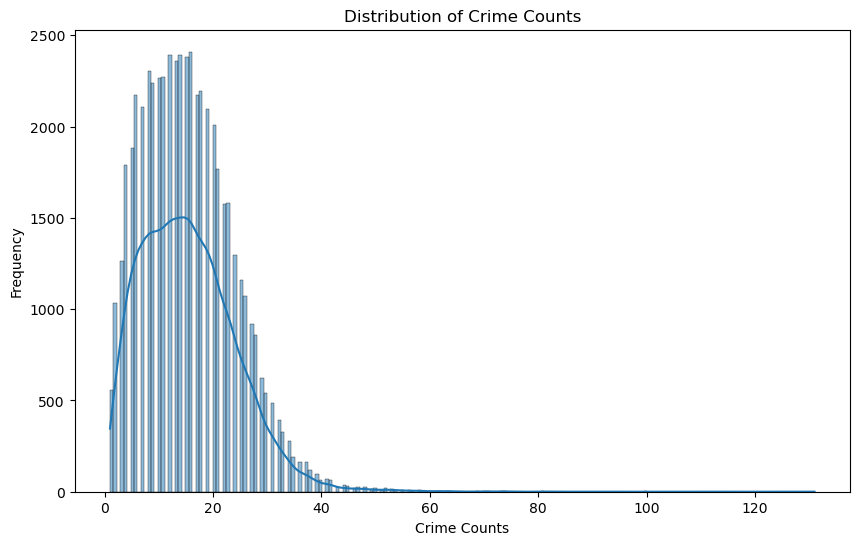

In [270]:
y = merged_SF4['crime count'].copy()


plt.figure(figsize=(10, 6))
sns.histplot(y, kde=True)
plt.title('Distribution of Crime Counts')
plt.xlabel('Crime Counts')
plt.ylabel('Frequency')
plt.show()

In [271]:
skewness = y.skew()
kurtosis = y.kurt()

print(f'Skewness: {skewness}')
print(f'Kurtosis: {kurtosis}')

Skewness: 1.0034971931157455
Kurtosis: 3.3641641929063764
